In [263]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from unidecode import unidecode

import plotly.express as px
import plotly.graph_objects as go

In [264]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Assessing UN City Population Projections
In 2018 the UN made population projections till 2035 for around 220 major African cities. Many of these cities have since performed a nation wide census and therefore have reliable city population figures. In this notebook, we will compare the UN projections to the actual populations of cities found during any census performed after 2018.

## File structure
The UN projections data is contained in a single csv. The country specific city population data is stored in separate folders, one per country. We need to navigate through this file structure to collect the city population figures for all countries. The starting directory for this notebook contains a folder called 'all_africa_countries_pop_and_city_data'. This folder contains a folder for every single African country. Inside each African country folder (e.g. inside the 'kenya' folder) are several csv files containing data for that country. 

Below we show an example process of navigating from the starting directory to find a specific population file for kenya: 

*Starting Directory* **-->** *all_africa_countries_pop_and_city_data* **-->** *kenya* **-->** *kenya_major_cities.csv*

## Combine All City Population Data
We need to find the **major cities** csv file for each country. They use the naming convention \[country\]_major_cities.csv e.g. for kenya it is kenya_major_cities.csv. 

We will begin by listing the contents of the starting directory:

In [265]:
os.listdir()

['.DS_Store',
 'all_africa_countries_pop_and_city_data',
 'rwanda_major_cities.csv',
 'data fixes.xlsx',
 'UN_city_pop_projections_long.csv',
 'UN_projections_compared',
 'compare_un_to_census.ipynb',
 '.ipynb_checkpoints']

Now we will go into the **all_africa_countries_pop_and_city_data** folder:

In [266]:
os.chdir('all_africa_countries_pop_and_city_data')

From here, we again list the files in this directory: 

In [267]:
os.listdir()

['kenya',
 'Botswana',
 'Benin',
 'Tunisia',
 'Tanzania',
 'Nambia',
 'Equitorial Guinea',
 'Zambia',
 '.DS_Store',
 'Ghana',
 'Gabon',
 'Malawi',
 'libya',
 'morocco',
 'Seychelles',
 'Liberia',
 'Central africa',
 'Sudan',
 'Lesotho',
 'Mali',
 'Nigeria',
 'Dijboiti',
 'Somalia',
 'Burkina',
 'Estwatini',
 'st.helana',
 'Algeria',
 'Dr Congo',
 'Angola',
 'camaroon',
 'Senegal',
 'mayotte',
 'Eriteria',
 'Ethiopia',
 'Togo',
 'Capeverde',
 'Mazambiqui',
 'Uganda',
 'chad',
 'Niger',
 'IvoryCoast',
 'Gambia',
 'Reunion',
 'Saotome',
 'Guinea',
 'South Africa',
 'sierra leone',
 'Zimbabve',
 'madagascar',
 'Mauritania',
 'Marituis',
 'Egypt',
 'comros',
 'Burundi',
 'Rawanda',
 'Bulawayo',
 'Congo_rep',
 'guineabissau']

We can see we have a different folder for each African country. We will now create a function that takes the folder name (e.g. a country name) and will open that folder, extract a list of the files in that folder and then return to the **all_africa_countries_pop_and_city_data** folder: 

In [268]:
def get_file_names(folder_name):
    os.chdir(folder_name)
    
    file_names = os.listdir()
    
    os.chdir('..')
    return file_names

In [269]:
folders = os.listdir()
# Remove the .DS_store file that github added to folder structure
folders = [folder for folder in folders if folder[0] != '.']

files = []
for folder in folders:
    file_names = get_file_names(folder)
    files.append([folder, file_names])

In [270]:
df = pd.DataFrame(files, columns=['country', 'files'])
df.head()

country                                              files
0     kenya  [rift valley, Kenya_major_cities.csv, nyanza, ...
1  Botswana  [cities_botswana.csv, botswana_Agglomerations....
2     Benin  [Cities_population_benin.csv, Benin_major_citi...
3   Tunisia  [Tunisia_Age_distribution.csv, Tunisia_age_pop...
4  Tanzania  [Tanzania_Admin _PopbyRegionandDistricts.csv, ...

In [271]:
def flatten_files(files): 
    flat_files = '\t'.join(files)
    flat_files = flat_files.lower()
    return flat_files.replace('_', '')


has_major_cities = [('majorcities' in flatten_files(files)) for files in df.files]
df['has_major_cities'] = has_major_cities
df

country                                              files  \
0               kenya  [rift valley, Kenya_major_cities.csv, nyanza, ...   
1            Botswana  [cities_botswana.csv, botswana_Agglomerations....   
2               Benin  [Cities_population_benin.csv, Benin_major_citi...   
3             Tunisia  [Tunisia_Age_distribution.csv, Tunisia_age_pop...   
4            Tanzania  [Tanzania_Admin _PopbyRegionandDistricts.csv, ...   
5              Nambia  [Nambia_gender_population.csv, Nambia_major_ci...   
6   Equitorial Guinea  [EquatorialGuinea_populationon (1).csv, Equato...   
7              Zambia  [Zambia_population.csv, Zambia_ward_admin_popu...   
8               Ghana  [Ghana_population.csv, Ghana_age_population.cs...   
9               Gabon  [Gabon_population.csv, Gabon_cities.csv, Gabon...   
10             Malawi  [Malawi_population.csv, malawi_age_distributio...   
11              libya  [libya_population.csv, libya_major_cities.csv,...   
12            morocco  [morocco_urbanization.csv, morocco_age_distrib...   
13         Seychelles  [seychelles_admin_population.csv, seychelles_a...   
14            Liberia  [liberia_major_cities.csv, liberia_population....   
15     Central africa  [centralafrica_cities.csv, CentralAfrica_Bengu...   
16              Sudan  [Sudan_Popby_town.csv, Sudan_Popbystates.csv, ...   
17            Lesotho  [lesotho_major_cities.csv, lesotho_population....   
18               Mali  [mali_cities.csv, mali_admin_population.csv, M...   
19            Nigeria  [Nigerian urban agglomerations.csv, Nigeria_Ag...   
20           Dijboiti  [Dijboiti_major_cities.csv, Dijboiti_populatio...   
21            Somalia       [Somalia_cities.csv, Somalia_population.csv]   
22            Burkina  [burkina_administrative.csv, burkina_municipal...   
23          Estwatini  [Eswatini_populationon.csv, Eswatini_cities.cs...   
24          st.helana  [Saint Helena_places.csv, Saint Helena_populat...   
25            Algeria  [population_algeria.csv, Algeria_cities_popula...   
26           Dr Congo  [DrCong_Popbymajorcities.csv, DrCongo_Popbycit...   
27             Angola  [Angola_Admin_PopbyGender.csv, Angola_Admin_Po...   
28           camaroon  [major_cities_camaroon.csv, camaroon_cities_po...   
29            Senegal  [senegal_admin_population.csv, senegal_urbaniz...   
30            mayotte  [Mayotte_major_cities.csv, Mayotte__population...   
31           Eriteria  [Eriteria_populationon.csv, Eriteria_major_cit...   
32           Ethiopia  [Ethiopia_population.csv, Ethiopia_administrat...   
33               Togo  [Togo_population.csv, Togo_cities.csv, togo_ad...   
34          Capeverde  [cape_verde_population.csv, cape_verde_cities....   
35         Mazambiqui  [mozambiqui_gender_population.csv, Mozambiqui_...   
36             Uganda  [uganda_urbanization.csv, uganda_gender_popula...   
37               chad  [chad_population.csv, chad_major_cities.csv, c...   
38              Niger  [Niger_population.csv, niger_urbanization_popu...   
39         IvoryCoast  [Ivory_Major_cities.csv, ivory_Administrative....   
40             Gambia  [Gambia_population.csv, Gambia_major_cities.cs...   
41            Reunion  [reunion_ arrondissements.csv, reunion_Major C...   
42            Saotome  [saotome_admin_population.csv, saotome_major_c...   
43             Guinea  [Conokary_age_population.csv, Guinea_populatio...   
44       South Africa  [SouthAfrica_Ekurhuleni_UrbanPop.csv, SouthAfr...   
45       sierra leone  [gender_District in Sierra Leone.csv, sierrale...   
46           Zimbabve  [Zimbabwe_gender_population.csv, .DS_Store, Zi...   
47         madagascar  [population_madagascar.csv, population_madagas...   
48         Mauritania  [Mauritania_admin_population.csv, Mauritania_c...   
49           Marituis  [mauritius_age_distribution.csv, Mauritius_maj...   
50              Egypt  [Egypt_Popbymajorcities.csv, Egypt_Popbygovern...   
51             comros  [Comros_admin.csv, comros_island_popula

In [272]:
df[df.has_major_cities == False]

country                                              files  \
1       Botswana  [cities_botswana.csv, botswana_Agglomerations....   
13    Seychelles  [seychelles_admin_population.csv, seychelles_a...   
19       Nigeria  [Nigerian urban agglomerations.csv, Nigeria_Ag...   
21       Somalia       [Somalia_cities.csv, Somalia_population.csv]   
24     st.helana  [Saint Helena_places.csv, Saint Helena_populat...   
25       Algeria  [population_algeria.csv, Algeria_cities_popula...   
27        Angola  [Angola_Admin_PopbyGender.csv, Angola_Admin_Po...   
41       Reunion  [reunion_ arrondissements.csv, reunion_Major C...   
44  South Africa  [SouthAfrica_Ekurhuleni_UrbanPop.csv, SouthAfr...   
51        comros  [Comros_admin.csv, comros_island_population.cs...   
53       Rawanda  [rawanda_citizenship.csv, rawanda_age_diastrib...   
54      Bulawayo  [Bulawayo_population.csv, Bulawayo_gender_popu...   

    has_major_cities  
1              False  
13             False  
19             False  
21             False  
24             False  
25             False  
27             False  
41             False  
44             False  
51             False  
53             False  
54             False

In [273]:
df.has_major_cities.sum()

45

In [274]:
def collect_major_city_csv(folder, country_data):
    os.chdir(folder)
    
    files = os.listdir()
    
    for file in files:
        file_cleaned = file.lower().replace('_','')
        if 'majorcities' in file_cleaned:
            country_data[folder] = pd.read_csv(file)
    
    os.chdir('..')
    return country_data

In [275]:
country_data = {}
for folder in folders: 
    country_data = collect_major_city_csv(folder, country_data)
    
len(country_data.keys())

45

## Merge City Population Data

In [276]:
for country, data in country_data.items():
    print(country)
    print(data.columns)

kenya
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Benin
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Tunisia
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Tanzania
Index(['Unnamed: 0', 'Name', 'Adm.', 'Population Census (C) 2012-08-26'], dtype='object')
Nambia
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Equitorial Guinea
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Zambia
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Ghana
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Gabon
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Malawi
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
libya
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
morocco
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Liberia
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Central africa
Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Sudan
Index(['Unnamed: 0', 'Name', 'Adm

In [277]:
def clean_df(df): 
    if df.columns[1] == '0': 
        new_header = df.iloc[0] #grab the first row for the header
        df = df[1:] #take the data less the header row
        df.columns = new_header #set the header row as the df header
    # Select all rows from 'Names' and further right 
    df = df.loc[:,'Name':]
    # Dijboiti had an extra column to right called 'Area', this removes
    if df.shape[1] > 3: 
        df = df.iloc[:,0:3]
    
    return df

In [278]:
for country, data in country_data.items():
    country_data[country] = clean_df(data)
    
for country, data in country_data.items():
    print(country)
    print(data.columns)

kenya
Index(['Name', 'Adm.', 'Population Census (C) 2019-08-24'], dtype='object', name=0)
Benin
Index(['Name', 'Adm.', 'Population Census (Cf) 2013-05-11'], dtype='object', name=0)
Tunisia
Index(['Name', 'Adm.', 'Population Estimate (E) 2022-01-01'], dtype='object', name=0)
Tanzania
Index(['Name', 'Adm.', 'Population Census (C) 2012-08-26'], dtype='object')
Nambia
Index(['Name', 'Adm.', 'Population Census (Cf) 2011-08-28'], dtype='object', name=0)
Equitorial Guinea
Index(['Name', 'Adm.', 'Population Calculation (UE-C) 2015-07-04'], dtype='object', name=0)
Zambia
Index(['Name', 'Adm.', 'Population Census (Cp) 2022-08-18'], dtype='object', name=0)
Ghana
Index(['Name', 'Adm.', 'Population Census (C) 2013-04-15'], dtype='object', name=0)
Gabon
Index(['Name', 'Adm.', 'Population Census (C) 2013-10-01'], dtype='object', name=0)
Malawi
Index(['Name', 'Adm.', 'Population Projection (P) 2020-09-03'], dtype='object', name=0)
libya
Index(['Name', 'Adm.', 'Population Estimate (E) 2020-01-01'], dty

In [279]:
for country, data in country_data.items():
    print(country)
    print(data.shape[1])

kenya
3
Benin
3
Tunisia
3
Tanzania
3
Nambia
3
Equitorial Guinea
3
Zambia
3
Ghana
3
Gabon
3
Malawi
3
libya
3
morocco
3
Liberia
3
Central africa
3
Sudan
3
Lesotho
3
Mali
3
Dijboiti
3
Burkina
3
Estwatini
3
Dr Congo
3
camaroon
3
Senegal
3
mayotte
3
Eriteria
3
Ethiopia
3
Togo
3
Capeverde
3
Mazambiqui
3
Uganda
3
chad
3
Niger
3
IvoryCoast
3
Gambia
3
Saotome
3
Guinea
3
sierra leone
3
Zimbabve
3
madagascar
3
Mauritania
3
Marituis
3
Egypt
3
Burundi
3
Congo_rep
3
guineabissau
3


In [280]:
# Go back to starting directory
os.chdir('..')
# Load rwanda data (was collected separately to the other data)
rwanda_data = pd.read_csv('rwanda_major_cities.csv')
rwanda_data

Name Adm. Population Census (C) 15/08/2022
0     Kigali  KIG                        1,517,168
1    Gisenyi  OUE                          270,000
2  Ruhengeri  NOR                          135,000
3   Gitarama  SUD                           85,000
4     Butare  SUD                             75,0

In [281]:
country_data['rwanda'] = rwanda_data

In [282]:
city_pop = pd.DataFrame()

for country, data in country_data.items():
    data['country'] = country
    city_pop = pd.concat([city_pop, data])
    
city_pop    

Name Adm. Population Census (C) 2019-08-24 country  \
1     Nairobi  NaN                        4,397,073   kenya   
2     Mombasa   CO                        1,208,333   kenya   
3      Nakuru   RV                          570,674   kenya   
4       Ruiru   CE                          490,120   kenya   
5     Eldoret   RV                          475,716   kenya   
..        ...  ...                              ...     ...   
0      Kigali  KIG                              NaN  rwanda   
1     Gisenyi  OUE                              NaN  rwanda   
2   Ruhengeri  NOR                              NaN  rwanda   
3    Gitarama  SUD                              NaN  rwanda   
4      Butare  SUD                              NaN  rwanda   

   Population Census (Cf) 2013-05-11 Population Estimate (E) 2022-01-01  \
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   
5                                NaN                                NaN   
..                               ...                                ...   
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

    Population Census (C) 2012-08-26 Population Census (Cf) 2011-08-28  \
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   
5                                NaN                               NaN   
..                               ...                               ...   
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

   Population Calculation (UE-C) 2015-07-04 Population Census (Cp) 2022-08-18  \
1                                       NaN                               NaN   
2                                       NaN                               NaN   
3                                       NaN                               NaN   
4                                       NaN                               NaN   
5                                       NaN                               NaN   
..                                      ...                               ...   
0                                       NaN                               NaN   
1                                       NaN                               NaN   
2                                       NaN                               NaN   
3                                       NaN                               NaN   
4                                       NaN                               NaN   

   Population Census (C) 2013-04-15 Population Census (C) 2013-10-01  \
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   
5                               NaN                              NaN   
..                              ...                      

## Format City Population Data

In [283]:
city_pop.drop(columns = ['Adm.'], inplace = True)
city_pop = city_pop.melt(['country','Name'], var_name = 'data_source', value_name = 'population')
city_pop.dropna(inplace = True)
city_pop = city_pop.reset_index(drop='True')

In [284]:
# extract date from data_source by selecting the first 10 elements of 
# the string from the right
city_pop['date_collected'] = city_pop.data_source.str[-10:]
# Convert to datetime
city_pop['date_collected'] = pd.to_datetime(city_pop.date_collected)

city_pop.data_source = city_pop.data_source.str[:-10].str.strip()

/opt/homebrew/Caskroom/miniforge/base/envs/geo/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning:

Parsing '15/08/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.



In [285]:
city_pop

country       Name            data_source population date_collected
0     kenya    Nairobi  Population Census (C)  4,397,073     2019-08-24
1     kenya    Mombasa  Population Census (C)  1,208,333     2019-08-24
2     kenya     Nakuru  Population Census (C)    570,674     2019-08-24
3     kenya      Ruiru  Population Census (C)    490,120     2019-08-24
4     kenya    Eldoret  Population Census (C)    475,716     2019-08-24
..      ...        ...                    ...        ...            ...
338  rwanda     Kigali  Population Census (C)  1,517,168     2022-08-15
339  rwanda    Gisenyi  Population Census (C)    270,000     2022-08-15
340  rwanda  Ruhengeri  Population Census (C)    135,000     2022-08-15
341  rwanda   Gitarama  Population Census (C)     85,000     2022-08-15
342  rwanda     Butare  Population Census (C)       75,0     2022-08-15

[343 rows x 5 columns]

In [286]:
UN_projection_date = dt.datetime(2018, 6, 1)
city_pop_after_UN = city_pop[city_pop.date_collected >= UN_projection_date]

city_pop_after_UN = city_pop_after_UN.copy()

city_pop_after_UN.country.unique()

array(['kenya', 'Tunisia', 'Zambia', 'Malawi', 'libya', 'morocco',
       'Central africa', 'Burkina', 'Eriteria', 'Ethiopia', 'Togo',
       'Capeverde', 'Uganda', 'IvoryCoast', 'sierra leone', 'Zimbabve',
       'madagascar', 'Marituis', 'Egypt', 'Congo_rep', 'rwanda'],
      dtype=object)

In [287]:
city_pop_after_UN.data_source.unique()

array(['Population Census (C)', 'Population Estimate (E)',
       'Population Census (Cp)', 'Population Projection (P)',
       'Population Calculation (UE-P)', 'Population Census (Cf)'],
      dtype=object)

In [288]:
city_pop_after_UN['year_data_collected'] = city_pop_after_UN.date_collected.dt.year
city_pop_after_UN['month_data_collected'] = city_pop_after_UN.date_collected.dt.month
city_pop_after_UN['years_since_UN_projection'] = city_pop_after_UN.year_data_collected - 2018

In [289]:
city_pop_after_UN

country       Name            data_source population date_collected  \
0     kenya    Nairobi  Population Census (C)  4,397,073     2019-08-24   
1     kenya    Mombasa  Population Census (C)  1,208,333     2019-08-24   
2     kenya     Nakuru  Population Census (C)    570,674     2019-08-24   
3     kenya      Ruiru  Population Census (C)    490,120     2019-08-24   
4     kenya    Eldoret  Population Census (C)    475,716     2019-08-24   
..      ...        ...                    ...        ...            ...   
338  rwanda     Kigali  Population Census (C)  1,517,168     2022-08-15   
339  rwanda    Gisenyi  Population Census (C)    270,000     2022-08-15   
340  rwanda  Ruhengeri  Population Census (C)    135,000     2022-08-15   
341  rwanda   Gitarama  Population Census (C)     85,000     2022-08-15   
342  rwanda     Butare  Population Census (C)       75,0     2022-08-15   

     year_data_collected  month_data_collected  years_since_UN_projection  
0                   2019                     8                          1  
1                   2019                     8                          1  
2                   2019                     8                          1  
3                   2019                     8                          1  
4                   2019                     8                          1  
..                   ...                   ...                        ...  
338                 2022                     8                          4  
339                 2022                     8                          4  
340                 2022                     8                          4  
341                 2022                     8                          4  
342                 2022                     8                          4  

[143 rows x 8 columns]

In [290]:
city_pop_after_UN['months_offset_from_midyear'] = city_pop_after_UN.month_data_collected - 6
city_pop_after_UN['year_offset_from_midyear'] = city_pop_after_UN.months_offset_from_midyear / 12
city_pop_after_UN

country       Name            data_source population date_collected  \
0     kenya    Nairobi  Population Census (C)  4,397,073     2019-08-24   
1     kenya    Mombasa  Population Census (C)  1,208,333     2019-08-24   
2     kenya     Nakuru  Population Census (C)    570,674     2019-08-24   
3     kenya      Ruiru  Population Census (C)    490,120     2019-08-24   
4     kenya    Eldoret  Population Census (C)    475,716     2019-08-24   
..      ...        ...                    ...        ...            ...   
338  rwanda     Kigali  Population Census (C)  1,517,168     2022-08-15   
339  rwanda    Gisenyi  Population Census (C)    270,000     2022-08-15   
340  rwanda  Ruhengeri  Population Census (C)    135,000     2022-08-15   
341  rwanda   Gitarama  Population Census (C)     85,000     2022-08-15   
342  rwanda     Butare  Population Census (C)       75,0     2022-08-15   

     year_data_collected  month_data_collected  years_since_UN_projection  \
0                   2019                     8                          1   
1                   2019                     8                          1   
2                   2019                     8                          1   
3                   2019                     8                          1   
4                   2019                     8                          1   
..                   ...                   ...                        ...   
338                 2022                     8                          4   
339                 2022                     8                          4   
340                 2022                     8                          4   
341                 2022                     8                          4   
342                 2022                     8                          4   

     months_offset_from_midyear  year_offset_from_midyear  
0                             2                  0.166667  
1                             2                  0.166667  
2                             2                  0.166667  
3                             2                  0.166667  
4                             2                  0.166667  
..                          ...                       ...  
338                           2                  0.166667  
339                           2                  0.166667  
340                           2                  0.166667  
341                           2                  0.166667  
342                           2                  0.166667  

[143 rows x 10 columns]

## Load UN Projections Data

In [291]:
# rename 'Name' column to 'city'
city_pop_after_UN.rename(columns = {'Name': 'city'}, inplace = True)
# Clean country and city columns to make lower case and remove white 
# space, helps when merging
city_pop_after_UN.city = city_pop_after_UN.city.str.lower().str.strip()
city_pop_after_UN.country = city_pop_after_UN.country.str.lower().str.strip()
city_pop_after_UN

country       city            data_source population date_collected  \
0     kenya    nairobi  Population Census (C)  4,397,073     2019-08-24   
1     kenya    mombasa  Population Census (C)  1,208,333     2019-08-24   
2     kenya     nakuru  Population Census (C)    570,674     2019-08-24   
3     kenya      ruiru  Population Census (C)    490,120     2019-08-24   
4     kenya    eldoret  Population Census (C)    475,716     2019-08-24   
..      ...        ...                    ...        ...            ...   
338  rwanda     kigali  Population Census (C)  1,517,168     2022-08-15   
339  rwanda    gisenyi  Population Census (C)    270,000     2022-08-15   
340  rwanda  ruhengeri  Population Census (C)    135,000     2022-08-15   
341  rwanda   gitarama  Population Census (C)     85,000     2022-08-15   
342  rwanda     butare  Population Census (C)       75,0     2022-08-15   

     year_data_collected  month_data_collected  years_since_UN_projection  \
0                   2019                     8                          1   
1                   2019                     8                          1   
2                   2019                     8                          1   
3                   2019                     8                          1   
4                   2019                     8                          1   
..                   ...                   ...                        ...   
338                 2022                     8                          4   
339                 2022                     8                          4   
340                 2022                     8                          4   
341                 2022                     8                          4   
342                 2022                     8                          4   

     months_offset_from_midyear  year_offset_from_midyear  
0                             2                  0.166667  
1                             2                  0.166667  
2                             2                  0.166667  
3                             2                  0.166667  
4                             2                  0.166667  
..                          ...                       ...  
338                           2                  0.166667  
339                           2                  0.166667  
340                           2                  0.166667  
341                           2                  0.166667  
342                           2                  0.166667  

[143 rows x 10 columns]

In [292]:
UN_data = pd.read_csv('UN_city_pop_projections_long.csv')
UN_data

Unnamed: 0  Region  Country_Code Country_or_area  City_Code  \
0               0  Africa            12         Algeria      20009   
1               1  Africa            12         Algeria      20011   
2               2  Africa            12         Algeria      20015   
3               3  Africa            12         Algeria      20006   
4               4  Africa            12         Algeria      20020   
...           ...     ...           ...             ...        ...   
19001       19001  Africa           894          Zambia      23277   
19002       19002  Africa           894          Zambia      23279   
19003       19003  Africa           716        Zimbabwe      22510   
19004       19004  Africa           716        Zimbabwe      22511   
19005       19005  Africa           716        Zimbabwe      22513   

                        City  \
0                     Annaba   
1                      Batna   
2                      Blida   
3      El Djazaïr  (Algiers)   
4                  El Djelfa   
...                      ...   
19001                 Lusaka   
19002                  Ndola   
19003               Bulawayo   
19004            Chitungwiza   
19005                 Harare   

                                         data_sources_UN      City_Definition  \
0      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...  Urban Agglomeration   
1      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...          City Proper   
2      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...  Urban Agglomeration   
3      Censuses of 1954, 1960, 1966, 1977, 1987, 1998...  Urban Agglomeration   
4                 Censuses of 1977, 1987, 1998 and 2008.  Urban Agglomeration   
...                                                  ...                  ...   
19001  Censuses of 1950, 1963, 1969, 1980, 1990, 2000...  Urban Agglomeration   
19002  Censuses of 1963, 1969, 1980, 1990, 2000 and 2...          City Proper   
19003  Censuses of 1951, 1956, 1962, 1973, 1982, 1992...          City Proper   
19004             Censuses of 1982, 1992, 2002 and 2012.          City Proper   
19005  Censuses of 1951, 1956, 1969, 1982, 1992, 2002...          City Proper   

        Latitude  Longitude  year  population  
0      36.900000   7.766670  1950      99.741  
1      35.555970   6.174140  1950      13.046  
2      36.480781   2.831943  1950      33.970  
3      36.752500   3.041970  1950     516.450  
4      34.672790   3.263000  1950      10.450  
...          ...        ...   ...         ...  
19001 -15.413374  28.277148  2035    5182.669  
19002 -12.958670  28.636590  2035     925.726  
19003 -20.150000  28.583330  2035     874.479  
19004 -18.012740  31.075550  2035     552.027  
19005 -17.829350  31.053890  2035    2141.738  

[19006 rows x 12 columns]

In [293]:
UN_data.Country_or_area = UN_data.Country_or_area.str.lower().str.strip()
UN_data.City = UN_data.City.str.lower().str.strip()
UN_data

Unnamed: 0  Region  Country_Code Country_or_area  City_Code  \
0               0  Africa            12         algeria      20009   
1               1  Africa            12         algeria      20011   
2               2  Africa            12         algeria      20015   
3               3  Africa            12         algeria      20006   
4               4  Africa            12         algeria      20020   
...           ...     ...           ...             ...        ...   
19001       19001  Africa           894          zambia      23277   
19002       19002  Africa           894          zambia      23279   
19003       19003  Africa           716        zimbabwe      22510   
19004       19004  Africa           716        zimbabwe      22511   
19005       19005  Africa           716        zimbabwe      22513   

                        City  \
0                     annaba   
1                      batna   
2                      blida   
3      el djazaïr  (algiers)   
4                  el djelfa   
...                      ...   
19001                 lusaka   
19002                  ndola   
19003               bulawayo   
19004            chitungwiza   
19005                 harare   

                                         data_sources_UN      City_Definition  \
0      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...  Urban Agglomeration   
1      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...          City Proper   
2      Censuses of 1954, 1966, 1977, 1987, 1998 and 2...  Urban Agglomeration   
3      Censuses of 1954, 1960, 1966, 1977, 1987, 1998...  Urban Agglomeration   
4                 Censuses of 1977, 1987, 1998 and 2008.  Urban Agglomeration   
...                                                  ...                  ...   
19001  Censuses of 1950, 1963, 1969, 1980, 1990, 2000...  Urban Agglomeration   
19002  Censuses of 1963, 1969, 1980, 1990, 2000 and 2...          City Proper   
19003  Censuses of 1951, 1956, 1962, 1973, 1982, 1992...          City Proper   
19004             Censuses of 1982, 1992, 2002 and 2012.          City Proper   
19005  Censuses of 1951, 1956, 1969, 1982, 1992, 2002...          City Proper   

        Latitude  Longitude  year  population  
0      36.900000   7.766670  1950      99.741  
1      35.555970   6.174140  1950      13.046  
2      36.480781   2.831943  1950      33.970  
3      36.752500   3.041970  1950     516.450  
4      34.672790   3.263000  1950      10.450  
...          ...        ...   ...         ...  
19001 -15.413374  28.277148  2035    5182.669  
19002 -12.958670  28.636590  2035     925.726  
19003 -20.150000  28.583330  2035     874.479  
19004 -18.012740  31.075550  2035     552.027  
19005 -17.829350  31.053890  2035    2141.738  

[19006 rows x 12 columns]

## Find UN City Projections We Can Test

### Filter UN data by countries in Population Census Data

In [294]:
city_countries = city_pop_after_UN.country.unique()
city_countries

array(['kenya', 'tunisia', 'zambia', 'malawi', 'libya', 'morocco',
       'central africa', 'burkina', 'eriteria', 'ethiopia', 'togo',
       'capeverde', 'uganda', 'ivorycoast', 'sierra leone', 'zimbabve',
       'madagascar', 'marituis', 'egypt', 'congo_rep', 'rwanda'],
      dtype=object)

In [295]:
def see_if_matched(item, column, df):
    return len(df[df[column].str.fullmatch(item)]) > 0

for country in city_countries: 
    match = see_if_matched(country, 'Country_or_area', UN_data)
    
    print(country, match)

kenya True
tunisia True
zambia True
malawi True
libya True
morocco True
central africa False
burkina False
eriteria False
ethiopia True
togo True
capeverde False
uganda True
ivorycoast False
sierra leone True
zimbabve False
madagascar True
marituis False
egypt True
congo_rep False
rwanda True


In [296]:
city_countries = city_pop_after_UN.country.unique()
city_countries

array(['kenya', 'tunisia', 'zambia', 'malawi', 'libya', 'morocco',
       'central africa', 'burkina', 'eriteria', 'ethiopia', 'togo',
       'capeverde', 'uganda', 'ivorycoast', 'sierra leone', 'zimbabve',
       'madagascar', 'marituis', 'egypt', 'congo_rep', 'rwanda'],
      dtype=object)

In [297]:
# Improvements: 
# - set which matchers to show (not just all), maybe with list of matcher names...
# unpack the results from tupple...advanced..pronbably not worth effort 

def get_scores(df_1, df_2, key1, key2, limit=2):
    fuzzy_methods = {'Ratio':fuzz.ratio, 'Partial_ratio':fuzz.partial_ratio, 
                 'token_set_ratio':fuzz.token_set_ratio, 
                 'Token_sort_ratio':fuzz.token_sort_ratio, 
                 'partial_token_set_ratio':fuzz.partial_token_set_ratio,
                'partial_token_sort_ratio':fuzz.partial_token_sort_ratio, 
                 'WRatio':fuzz.WRatio}
    
    
    keys1 = df_1[key1].unique()
    keys2 = df_2[key2].unique()
    
    scores = [apply_fuzzy_scores(key, keys2, limit, fuzzy_methods) for key in keys1]
    
    return pd.DataFrame(scores, columns = ['key'] + list(fuzzy_methods.keys()))
    
    
def apply_fuzzy_scores(key, keys2, limit, fuzzy_methods):
    """loop through (as dic comp) every scorer for the process.extract and then 
    return list of lists of results, but also inclide key at front e.g. country """
    
    scores  = [process.extract(key, keys2, limit=limit, scorer = method)  for method in fuzzy_methods.values()]
    
    return [key] + scores

In [298]:
# match countries in city_pop_after_UN to countries in UN_data
get_scores(df_1 = city_pop_after_UN, df_2 = UN_data, key1 = 'country', 
           key2 = 'Country_or_area', limit = 2)

key                                              Ratio  \
0            kenya                      [(kenya, 100), (senegal, 50)]   
1          tunisia                    [(tunisia, 100), (namibia, 57)]   
2           zambia                      [(zambia, 100), (gambia, 83)]   
3           malawi                        [(malawi, 100), (mali, 80)]   
4            libya                      [(libya, 100), (liberia, 67)]   
5          morocco                   [(morocco, 100), (cameroon, 53)]   
6   central africa  [(central african republic, 74), (south africa...   
7          burkina                 [(burkina faso, 74), (guinea, 62)]   
8         eriteria                     [(eritrea, 80), (liberia, 67)]   
9         ethiopia                   [(ethiopia, 100), (tunisia, 53)]   
10            togo                         [(togo, 100), (congo, 67)]   
11       capeverde                       [(cameroon, 47), (chad, 46)]   
12          uganda                       [(uganda, 100), (ghana, 73)]   
13      ivorycoast                       [(morocco, 47), (libya, 40)]   
14    sierra leone               [(sierra leone, 100), (eritrea, 42)]   
15        zimbabve                     [(zimbabwe, 88), (zambia, 57)]   
16      madagascar                   [(madagascar, 100), (ghana, 40)]   
17        marituis                  [(mauritania, 67), (tunisia, 53)]   
18           egypt                        [(egypt, 100), (kenya, 40)]   
19       congo_rep                          [(congo, 71), (togo, 46)]   
20          rwanda                      [(rwanda, 100), (uganda, 67)]   

                                        Partial_ratio  \
0                  [(kenya, 100), (burkina faso, 60)]   
1                    [(tunisia, 100), (ethiopia, 57)]   
2                       [(zambia, 100), (gambia, 83)]   
3                         [(malawi, 100), (mali, 75)]   
4                       [(libya, 100), (liberia, 60)]   
5                    [(morocco, 100), (cameroon, 62)]   
6   [(central african republic, 100), (south afric...   
7                 [(burkina faso, 100), (guinea, 67)]   
8                      [(eritrea, 71), (liberia, 71)]   
9                    [(ethiopia, 100), (tunisia, 57)]   
10                         [(togo, 100), (congo, 75)]   
11                       [(cameroon, 50), (chad, 50)]   
12                       [(uganda, 100), (ghana, 80)]   
13                        [(morocco, 57), (chad, 50)]   
14                 [(sierra leone, 100), (niger, 60)]   
15                     [(zimbabwe, 88), (zambia, 67)]   
16                  [(madagascar, 100), (angola, 50)]   
17                     [(mali, 75), (mauritania, 62)]   
18                        [(egypt, 100), (kenya, 44)]   
19                         [(congo, 100), (togo, 75)]   
20                      [(rwanda, 100), (uganda, 67)]   

                                      token_set_ratio  \
0                       [(kenya, 100), (senegal, 50)]   
1                     [(tunisia, 100), (namibia, 57)]   
2                       [(zambia, 100), (gambia, 83)]   
3                         [(malawi, 100), (mali, 80)]   
4                       [(libya, 100), (liberia, 67)]   
5                    [(morocco, 100), (cameroon, 53)]   
6   [(central african republic, 74), (south africa...   
7                 [(burkina faso, 100), (guinea, 62)]   
8                      [(eritrea, 80), (liberia, 67)]   
9                    [(ethiopia, 100), (tunisia, 53)]   
10                         [(togo, 100), (congo, 67)]   
11              [(côte d'ivoire, 48), (cameroon, 47)]   
12                       [(uganda, 100), (ghana, 73)]   
13                [(morocco, 47), (south africa, 45)]   
14               [(sierra leone, 100), (liberia, 53)]   
15                     [(zimbabwe, 88), (zambia, 57)]   
16                   [(madagascar, 100), (ghana, 40)]   
17                  [(mauritania, 67), (tunisia, 53)]   
18                        [(egypt, 100), (kenya, 40)]   
19           

In [299]:
# Note - UN data does not predict Mauritius ir capeverde and so we cannot use this data.

un_country_name = {'central africa':'central african republic',
                  'burkina':'burkina faso',
                  'eriteria':'eritrea',
                  'ivorycoast':'côte d\'ivoire',
                  'zimbabve':'zimbabwe',
                  'congo_rep':'congo'}

In [300]:
# map city country name to UN name (if not mapped, will be made nan)
city_pop_after_UN['country_in_UN'] = city_pop_after_UN.country.map(un_country_name)
# replace nans with original country name
city_pop_after_UN['country_in_UN'] = city_pop_after_UN['country_in_UN'].fillna(city_pop_after_UN.country)
city_pop_after_UN.country_in_UN.unique()

array(['kenya', 'tunisia', 'zambia', 'malawi', 'libya', 'morocco',
       'central african republic', 'burkina faso', 'eritrea', 'ethiopia',
       'togo', 'capeverde', 'uganda', "côte d'ivoire", 'sierra leone',
       'zimbabwe', 'madagascar', 'marituis', 'egypt', 'congo', 'rwanda'],
      dtype=object)

### Identity Cities In UN Data That we Can test

In [301]:
cities_in_scope = pd.merge(left = UN_data, right = city_pop_after_UN, how = 'inner', 
                           left_on='Country_or_area', right_on = 'country_in_UN', 
                           suffixes =('_UN','_census'))

cities_in_scope.head()

Unnamed: 0  Region  Country_Code Country_or_area  City_Code  \
0          21  Africa           854    burkina faso      23191   
1          21  Africa           854    burkina faso      23191   
2          21  Africa           854    burkina faso      23191   
3          21  Africa           854    burkina faso      23191   
4          21  Africa           854    burkina faso      23191   

             City                                    data_sources_UN  \
0  bobo-dioulasso  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...   
1  bobo-dioulasso  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...   
2  bobo-dioulasso  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...   
3  bobo-dioulasso  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...   
4  bobo-dioulasso  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...   

  City_Definition  Latitude  Longitude  year  population_UN  country  \
0     City Proper  11.17715    -4.2979  1950         36.114  burkina   
1     City Proper  11.17715    -4.2979  1950         36.114  burkina   
2     City Proper  11.17715    -4.2979  1950         36.114  burkina   
3     City Proper  11.17715    -4.2979  1950         36.114  burkina   
4     City Proper  11.17715    -4.2979  1950         36.114  burkina   

             city             data_source population_census date_collected  \
0     ouagadougou  Population Census (Cf)         2,415,266     2019-11-16   
1  bobo-dioulasso  Population Census (Cf)           904,920     2019-11-16   
2       koudougou  Population Census (Cf)           160,239     2019-11-16   
3           saaba  Population Census (Cf)           136,011     2019-11-16   
4      ouahigouya  Population Census (Cf)           124,587     2019-11-16   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2019                    11                          1   
3                 2019                    11                          1   
4                 2019                    11                          1   

   months_offset_from_midyear  year_offset_from_midyear country_in_UN  
0                           5                  0.416667  burkina faso  
1                           5                  0.416667  burkina faso  
2                           5                  0.416667  burkina faso  
3                           5                  0.416667  burkina faso  
4                           5                  0.416667  burkina faso

In [302]:
len(cities_in_scope.Country_or_area.unique())

19

In [303]:
cities_in_scope.Country_or_area.unique()

array(['burkina faso', 'central african republic', 'congo',
       "côte d'ivoire", 'egypt', 'eritrea', 'ethiopia', 'kenya', 'libya',
       'madagascar', 'malawi', 'morocco', 'rwanda', 'sierra leone',
       'togo', 'tunisia', 'uganda', 'zambia', 'zimbabwe'], dtype=object)

Confirmed above that all 18 matching countries in city_pop_after_UN matched in the UN data. We can now find out what cities are in the UN that we can compare to our recent census data: 

In [304]:
un_cities = cities_in_scope.City.unique()
un_cities

array(['bobo-dioulasso', 'ouagadougou', 'bangui', 'brazzaville',
       'pointe-noire', 'abidjan', 'bouake', 'al-fayyum',
       'al-iskandariyah (alexandria)', 'al-ismailiyah',
       'al-mahallah al-kubra', 'al-mansurah', 'al-qahirah (cairo)',
       'as-suways', 'aswan', 'asyut', 'az-zaqazig', "bur sa'id",
       'kafr-ad-dawwar', 'tanta', 'asmara', 'addis ababa', 'dire dawa',
       'gondar', 'mekele', 'nazret', 'eldoret', 'kisumu', 'mombasa',
       'nairobi', 'nakuru', 'ruiru', 'banghazi', 'misratah',
       'tarabulus (tripoli)', 'antananarivo', 'antsirabe', 'toamasina',
       'blantyre-limbe', 'lilongwe', 'agadir',
       'dar-el-beida (casablanca)', 'fès', 'kénitra', 'marrakech',
       'meknès', 'oujda', 'rabat', 'safi', 'tanger', 'tétouan', 'kigali',
       'freetown', 'lomé', 'safaqis', 'tunis', 'kampala', 'kitwe',
       'lusaka', 'ndola', 'bulawayo', 'chitungwiza', 'harare'],
      dtype=object)

In [305]:
len(un_cities)

63

We are trying to match with 63 UN cities.

## Match UN Data to City Population Data

Now we will compare these city names to the city names in the city population census data: 

In [306]:
unidecode('meknès')

'meknes'

Found that bracketed english names and special language characters were causing issues in matching city names, so removed both" 

In [307]:
# example string cleaning
unidecode('meknès')

'meknes'

In [308]:
# clean city names in city_pop_after_UN  
city_pop_after_UN['city_cleaned'] = [unidecode(city) 
                                     for city 
                                     in city_pop_after_UN.city]

city_pop_after_UN.city_cleaned.unique()

array(['nairobi', 'mombasa', 'nakuru', 'ruiru', 'eldoret', 'kisumu',
       'kikuyu', 'thika', 'naivasha', 'karuri', 'tunis', 'safaqis',
       'susah', 'al-qayrawan', 'banzart', 'sukrah', 'sidi husayn',
       'lusaka', 'kitwe', 'ndola', 'kabwe', 'chingola', 'lilongwe',
       'blantyre', 'mzuzu', 'zomba', 'tarabulus', 'banghazi', 'misratah',
       'casablanca', 'fes', 'tanger', 'sale', 'marrakech', 'oujda',
       'meknes', 'rabat', 'agadir', 'kenitra', 'bangui', 'bimbo',
       'begoua', 'carnot', 'berberati', 'bambari', 'bouar', 'bossangoa',
       'kaga-bandoro', 'bangassou', 'ouagadougou', 'bobo-dioulasso',
       'koudougou', 'saaba', 'ouahigouya', 'kaya', 'banfora', 'pouytenga',
       'hounde', "fada n'gourma", 'asmera', 'adis abeba', 'gonder',
       'mekele', 'adama', 'awasa', 'bahir dar', 'dire dawa', 'dese',
       'jima', 'lome', 'kara', 'sokode', 'kpalime', 'atakpame', 'dapaong',
       'tsevie', 'praia', 'mindelo', 'espargos', 'assomada', 'tarrafal',
       'porto novo

In [309]:
# match countries in city_pop_after_UN to countries in UN_data
get_scores(df_1 = cities_in_scope, df_2 = city_pop_after_UN, key1 = 'City', 
           key2 = 'city_cleaned', limit = 2)

key  \
0                 bobo-dioulasso   
1                    ouagadougou   
2                         bangui   
3                    brazzaville   
4                   pointe-noire   
5                        abidjan   
6                         bouake   
7                      al-fayyum   
8   al-iskandariyah (alexandria)   
9                  al-ismailiyah   
10          al-mahallah al-kubra   
11                   al-mansurah   
12            al-qahirah (cairo)   
13                     as-suways   
14                         aswan   
15                         asyut   
16                    az-zaqazig   
17                     bur sa'id   
18                kafr-ad-dawwar   
19                         tanta   
20                        asmara   
21                   addis ababa   
22                     dire dawa   
23                        gondar   
24                        mekele   
25                        nazret   
26                       eldoret   
27                        kisumu   
28                       mombasa   
29                       nairobi   
30                        nakuru   
31                         ruiru   
32                      banghazi   
33                      misratah   
34           tarabulus (tripoli)   
35                  antananarivo   
36                     antsirabe   
37                     toamasina   
38                blantyre-limbe   
39                      lilongwe   
40                        agadir   
41     dar-el-beida (casablanca)   
42                           fès   
43                       kénitra   
44                     marrakech   
45                        meknès   
46                         oujda   
47                         rabat   
48                          safi   
49                        tanger   
50                       tétouan   
51                        kigali   
52                      freetown   
53                          lomé   
54                       safaqis   
55                         tunis   
56                       kampala   
57                         kitwe   
58                        lusaka   
59                         ndola   
60                      bulawayo   
61                   chitungwiza   
62                        harare   

                                                Ratio  \
0             [(bobo-dioulasso, 100), (bulawayo, 45)]   
1               [(ouagadougou, 100), (koudougou, 80)]   
2                     [(bangui, 100), (banghazi, 71)]   
3                 [(brazzaville, 100), (banzart, 44)]   
4             [(pointe-noire, 100), (porto novo, 55)]   
5                       [(abidjan, 100), (rabat, 50)]   
6                        [(bouake, 100), (bouar, 73)]   
7               [(al-fayyum, 100), (al-qayrawan, 50)]   
8   [(al-iskandariyah, 71), (al-mahallah al-kubra,...   
9           [(al-iskandariyah, 71), (al-qahirah, 61)]   
10   [(al-mahallah al-kubra, 100), (al-mansurah, 52)]   
11             [(al-mansurah, 100), (al-qahirah, 67)]   
12              [(al-qahirah, 74), (al-qayrawan, 57)]   
13                    [(as-suways, 100), (awasa, 57)]   
14                       [(nansana, 67), (awasa, 60)]   
15                         [(asyut, 100), (kaya, 44)]   
16              [(al-qahirah, 50), (brazzaville, 48)]   
17                  [(bur sa'id, 100), (sal rei, 50)]   
18                 [(bahir dar, 52), (dire dawa, 52)]   
19                    [(tanta, 100), (toamasina, 57)]   
20                     [(asmera, 83), (assomada, 71)]   
21                    [(adis abeba, 86), (saaba, 62)]   
22                [(dire dawa, 100), (bahir dar, 56)]   
23                        [(gonder, 83), (ndola, 55)]   
24                      [(mekele, 100), (meknes, 67)]   
25                      [(banzart, 62), (nakuru, 50)]   
26                    [(eldoret, 100), (epworth, 57)]   
27                      [(kisumu, 100), (kikuyu, 67)]   
28                      [(mombasa, 100), (zomba, 67)]   
29            

Identified that Token Set Ratio is best fuzzy matching method for this because it can identify either the main name or a bracketed name e.g. gets 100% match on both dar-el-beida (casablanca) when it has casablanca or dar-el-beida. 

Also gives low scores (less than 80) for incorrect matches. So generally a reliable matcher. 

In [310]:
def create_fuzzy_match_key(df_1, df_2, key1, key2, method = 'WRatio', threshold = 90):
    fuzzy_methods = {'Ratio':fuzz.ratio, 'Partial_ratio':fuzz.partial_ratio, 
                 'token_set_ratio':fuzz.token_set_ratio, 
                 'Token_sort_ratio':fuzz.token_sort_ratio, 
                 'partial_token_set_ratio':fuzz.partial_token_set_ratio,
                'partial_token_sort_ratio':fuzz.partial_token_sort_ratio, 
                 'WRatio':fuzz.WRatio}
    
    method = fuzzy_methods[method]
    
    keys1 = df_1[key1].unique()
    keys2 = df_2[key2].unique()
    
    key_map = {key:fuzzy_match(key, keys2, method, threshold) for key in keys1}
    
    df_1[key1 + '_fuzzy_match'] = df_1[key1].map(key_map)
    
    return df_1
    
    
def fuzzy_match(key, keys2, method, threshold):
    """blurg """
    
    match = process.extract(key, keys2, limit = 1, scorer = method)[0]
    score = match[1]
    string = match[0]
    
    if score >= threshold: 
        return string
    
    return np.nan

In [311]:
# drop the old matching data (used to create the cities in scope...)
cities_in_scope = cities_in_scope.loc[:,'Region':'population_UN']
# remove duplicates from match
cities_in_scope = cities_in_scope.drop_duplicates().reset_index(drop = True)

In [312]:
cities_in_scope = create_fuzzy_match_key(cities_in_scope, city_pop_after_UN, 'City', 
                       'city_cleaned', method = 'token_set_ratio', 
                       threshold = 79)
cities_in_scope

Region  Country_Code Country_or_area  City_Code            City  \
0     Africa           854    burkina faso      23191  bobo-dioulasso   
1     Africa           854    burkina faso      23192     ouagadougou   
2     Africa           854    burkina faso      23191  bobo-dioulasso   
3     Africa           854    burkina faso      23192     ouagadougou   
4     Africa           854    burkina faso      23191  bobo-dioulasso   
...      ...           ...             ...        ...             ...   
5413  Africa           716        zimbabwe      22511     chitungwiza   
5414  Africa           716        zimbabwe      22513          harare   
5415  Africa           716        zimbabwe      22510        bulawayo   
5416  Africa           716        zimbabwe      22511     chitungwiza   
5417  Africa           716        zimbabwe      22513          harare   

                                        data_sources_UN City_Definition  \
0     Censuses of 1951, 1960, 1975, 1985, 1996 and 2...     City Proper   
1     Censuses of 1951, 1960, 1975, 1985, 1996 and 2...     City Proper   
2     Censuses of 1951, 1960, 1975, 1985, 1996 and 2...     City Proper   
3     Censuses of 1951, 1960, 1975, 1985, 1996 and 2...     City Proper   
4     Censuses of 1951, 1960, 1975, 1985, 1996 and 2...     City Proper   
...                                                 ...             ...   
5413             Censuses of 1982, 1992, 2002 and 2012.     City Proper   
5414  Censuses of 1951, 1956, 1969, 1982, 1992, 2002...     City Proper   
5415  Censuses of 1951, 1956, 1962, 1973, 1982, 1992...     City Proper   
5416             Censuses of 1982, 1992, 2002 and 2012.     City Proper   
5417  Censuses of 1951, 1956, 1969, 1982, 1992, 2002...     City Proper   

      Latitude  Longitude  year  population_UN City_fuzzy_match  
0     11.17715   -4.29790  1950         36.114   bobo-dioulasso  
1     12.36423   -1.53834  1950         33.035      ouagadougou  
2     11.17715   -4.29790  1951         38.000   bobo-dioulasso  
3     12.36423   -1.53834  1951         37.300      ouagadougou  
4     11.17715   -4.29790  1952         39.536   bobo-dioulasso  
...        ...        ...   ...            ...              ...  
5413 -18.01274   31.07555  2034        535.060      chitungwiza  
5414 -17.82935   31.05389  2034       2075.912           harare  
5415 -20.15000   28.58333  2035        874.479         bulawayo  
5416 -18.01274   31.07555  2035        552.027      chitungwiza  
5417 -17.82935   31.05389  2035       2141.738           harare  

[5418 rows x 12 columns]

How many of the 63 cities ata are matching with a city from the census data? 

In [313]:
matched_cities = cities_in_scope.dropna()
len(matched_cities.City.unique())

56

Not bad, we have lost about 7 cities...presumably they did not have real wor4ld data available...

In [314]:
len(matched_cities.Country_or_area.unique())

19

We still have all 19 countries represented.

In [315]:
cities = pd.merge(left = matched_cities, right = city_pop_after_UN, 
                  left_on = ['Country_or_area','City_fuzzy_match', 'year'], 
                  right_on = ['country_in_UN', 'city_cleaned',
                              'year_data_collected'], 
                  suffixes=('_UN', '_census'))
cities.head(10)

Region  Country_Code           Country_or_area  City_Code  \
0  Africa           854              burkina faso      23191   
1  Africa           854              burkina faso      23192   
2  Africa           140  central african republic      20410   
3  Africa           178                     congo      20848   
4  Africa           178                     congo      20849   
5  Africa           384             côte d'ivoire      21602   
6  Africa           384             côte d'ivoire      21603   
7  Africa           818                     egypt      22814   
8  Africa           818                     egypt      22804   
9  Africa           818                     egypt      22806   

                           City  \
0                bobo-dioulasso   
1                   ouagadougou   
2                        bangui   
3                   brazzaville   
4                  pointe-noire   
5                       abidjan   
6                        bouake   
7                     al-fayyum   
8  al-iskandariyah (alexandria)   
9          al-mahallah al-kubra   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   
5  Censuses of 1950, 1955, 1975, 1988, 1998 and 2...          City Proper   
6  Censuses of 1958, 1975, 1988, 1998 and 2014; E...          City Proper   
7  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...          City Proper   
8  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...          City Proper   
9  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...          City Proper   

    Latitude  Longitude  year  population_UN      City_fuzzy_match  \
0  11.177150  -4.297900  2019        924.370        bobo-dioulasso   
1  12.364230  -1.538340  2019       2652.720           ouagadougou   
2   4.361220  18.554960  2021        910.270                bangui   
3  -4.265830  15.283180  2019       2308.076           brazzaville   
4  -4.776090  11.863520  2019       1175.513          pointe-noire   
5   5.345339  -4.026789  2021       5354.826               abidjan   
6   7.693850  -5.030310  2021        580.586                bouake   
7  29.309950  30.841800  2021        417.077             al-fayyum   
8  31.192471  29.904596  2021       5381.101       al-iskandariyah   
9  30.974500  31.164990  2021        523.903  al-mahallah al-kubra   

          country                  city                data_source population  \
0         burkina        bobo-dioulasso     Population Census (Cf)    904,920   
1         burkina           ouagadougou     Population Census (Cf)  2,415,266   
2  central africa                bangui    Population Estimate (E)    812,407   
3       congo_rep           brazzaville  Population Projection (P)  1,982,000   
4       congo_rep          pointe-noire  Population Projection (P)  1,032,000   
5      ivorycoast               abidjan      Population Census (C)  5,616,633   
6      ivorycoast                bouaké      Population Census (C)    740,000   
7           egypt             al-fayyūm    Population Estimate (E)   519047.0   
8           egypt       al-iskandariyah    Population Estimate (E)  5263542.0   
9           egypt  al-maḥallah al-kubrā    Population Estimate (E)   592573.0   

  date_collected  year_data_collected  month_data_collected  \
0     2019-11-16                 2019                    11   
1     2019-11-16                 2019                    11   
2     2021-03-01                 2021                     3   
3     2019-07-01                 2019                     7   
4     2019-07-01                 2019                     7   
5     2021-12-14       

To do: 

- check na columns of fuzzy match...did I lose some stuff? 
Fun analysis!
- manually check the Uganda - kampala UN vs City pop De numbers because they are WAAAY off 
- Breakdown of numbers of census types
- Create comparison (+-) and calculater average and standard deviation and plot graph of different cities, maybe a cool plot conveying error and stuff...line plot with central line as correct....or big and small country size to show time since or population or something....
- Review column headers and have fun! what is interesting....


Secondly: 
- Add sections and basic text at least...hopefully...

## Fix Agglommeration Data

In [316]:
agglom_city_projs = cities[cities.City_Definition != 'City Proper'].copy()
agglom_city_projs

Region  Country_Code           Country_or_area  City_Code  \
2   Africa           140  central african republic      20410   
11  Africa           818                     egypt      22812   
28  Africa           434                     libya      21781   
30  Africa           450                madagascar      21792   
35  Africa           504                   morocco      21888   
36  Africa           504                   morocco      21891   
37  Africa           504                   morocco      21893   
42  Africa           504                   morocco      21899   
43  Africa           504                   morocco      21903   
46  Africa           768                      togo      22628   
47  Africa           788                   tunisia      22644   
48  Africa           788                   tunisia      22646   
49  Africa           800                    uganda      22744   
51  Africa           894                    zambia      23277   

                         City  \
2                      bangui   
11         al-qahirah (cairo)   
28                   misratah   
30               antananarivo   
35                     agadir   
36  dar-el-beida (casablanca)   
37                        fès   
42                      rabat   
43                     tanger   
46                       lomé   
47                    safaqis   
48                      tunis   
49                    kampala   
51                     lusaka   

                                      data_sources_UN      City_Definition  \
2   Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
11  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...    Metropolitan area   
28  Censuses of 1964, 1973 and 1984; Estimate for ...  Urban Agglomeration   
30  Censuses of 1975 and 1993; Estimates for 1952,...  Urban Agglomeration   
35  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...  Urban Agglomeration   
36  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...  Urban Agglomeration   
37  Censuses of 1971, 1982, 1994, 2004 and 2014; E...  Urban Agglomeration   
42  Censuses of 1952, 1960, 1971, 1982, 1994, 2004...  Urban Agglomeration   
43  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...  Urban Agglomeration   
46  Censuses of 1970, 1981 and 2010; Estimates for...  Urban Agglomeration   
47  Censuses of 1956, 1966, 1975, 1984, 2004 and 2...  Urban Agglomeration   
48  Censuses of 1956, 1966, 1984, 1994, 2004 and 2...  Urban Agglomeration   
49       Censuses of 1959, 1969, 1980, 1991 and 2014.  Urban Agglomeration   
51  Censuses of 1950, 1963, 1969, 1980, 1990, 2000...  Urban Agglomeration   

     Latitude  Longitude  year  population_UN City_fuzzy_match  \
2    4.361220  18.554960  2021        910.270           bangui   
11  30.039173  31.239411  2021      21322.750       al-qahirah   
28  32.375350  15.092540  2020        881.319         misratah   
30 -18.913680  47.536130  2018       3058.387     antananarivo   
35  30.424847  -9.593695  2020        923.552           agadir   
36  33.592780  -7.619160  2020       3752.357       casablanca   
37  34.037150  -4.999800  2020       1224.080              fes   
42  34.013250  -6.832550  2020       1884.802            rabat   
43  35.784722  -5.812778  2020       1197.923           tanger   
46   6.137480   1.212270  2020       1827.878             lome   
47  34.748471  10.756162  2022        643.334          safaqis   
48  36.818970  10.165790  2022       2439.404            tunis   
49   0.316280  32.582190  2020       3298.364          kampala   
51 -15.413374  28.277148  2022       3041.789           lusaka   

           country          city                    data_source population  \
2   central africa        bangui        Population Estimate (E)    812,407   
11           egypt    al-qāhirah        Population Estimate (E)  9606916.0   
28           libya      miṣrātah        Population Estimate (E)    360,000   
30      madagascar  antananarivo         Population Census

Logic - if it says urban agglommeration, if we have that data we switch, if we do not, we drop, we dont have appropriate comparable data...

In [317]:
url = 'https://citypopulation.de/en/world/agglomerations/'
agglom_data = pd.read_html(url)[0]
agglom_data.head()

Rank       Name English Name    Country  Population   Status  \
0     1  Guăngzhōu       Canton      China    67800000  Adm-Urb   
1     2      Tōkyō        Tokyo      Japan    40800000     Aggl   
2     3   Shànghăi     Shanghai      China    40000000  Adm-Urb   
3     4      Delhi        Delhi      India    33400000    Congl   
4     5    Jakarta      Jakarta  Indonesia    28900000     Aggl   

                                              Remark  
0  Northern Pearl River Delta; incl. Dōngguān, Fó...  
1  incl. Chiba, Kawasaki, Maebashi, Sagamihara, S...  
2            incl. Chángshú, Chángzhōu, Sūzhōu, Wúxī  
3                incl. Faridabad, Ghaziabad, Gurgaon  
4  incl. Bekasi, Bogor, Depok, Tangerang, Tangera...

In [318]:
get_scores(df_1 = agglom_city_projs, df_2 = agglom_data, key1 = 'city', 
           key2 = 'Name', limit = 2)

key                                     Ratio  \
0         bangui             [(Bangui, 100), (Banjul, 67)]   
1     al-qāhirah      [(Al-Qāhirah, 100), (Al-Baṣrah, 63)]   
2       miṣrātah         [(Amritsar, 50), (Al-Baṣrah, 47)]   
3   antananarivo  [(Antananarivo, 100), (San Antonio, 61)]   
4         agadir            [(Agadir, 100), (Gwalior, 62)]   
5     casablanca      [(Casablanca, 100), (La Habana, 63)]   
6            fès                [(Fès, 100), (Fresno, 44)]   
7          rabat                 [(Rabat, 100), (Aba, 75)]   
8         tanger            [(Tanger, 100), (Angeles, 62)]   
9           lomé                  [(Lomé, 100), (Qom, 57)]   
10       ṣafāqis               [(Paris, 50), (Ṣan'ā', 50)]   
11         tūnis             [(Tūnis, 100), (Athínai, 50)]   
12       kampala             [(Kampala, 100), (Tampa, 67)]   
13        lusaka              [(Lusaka, 100), (Ōsaka, 73)]   

                          Partial_ratio                       token_set_ratio  \
0      [(Bangui, 100), (Palembang, 80)]         [(Bangui, 100), (Banjul, 67)]   
1     [(Al-Qāhirah, 100), (Ṣan'ā', 60)]  [(Al-Qāhirah, 100), (Al-Baṣrah, 63)]   
2            [(Perth, 60), (Praha, 60)]     [(Amritsar, 50), (Al-Baṣrah, 47)]   
3   [(Antananarivo, 100), (Astana, 83)]  [(Antananarivo, 100), (Athínai, 56)]   
4    [(Agadir, 100), (Ouagadougou, 67)]        [(Agadir, 100), (Gwalior, 62)]   
5    [(Casablanca, 100), (Atlanta, 71)]     [(Casablanca, 100), (Astana, 62)]   
6             [(Fès, 100), (Lagos, 33)]            [(Fès, 100), (Fresno, 50)]   
7            [(Rabat, 100), (Aba, 100)]             [(Rabat, 100), (Aba, 75)]   
8    [(Tanger, 100), (Los Angeles, 67)]        [(Tanger, 100), (Angeles, 62)]   
9          [(Lomé, 100), (Colombo, 75)]              [(Lomé, 100), (Qom, 67)]   
10   [(Ṣan'ā', 60), (Barquisimeto, 57)]              [(Paris, 50), (Fès, 44)]   
11  [(Tūnis, 100), (San Francisco, 60)]         [(Tūnis, 100), (Athínai, 55)]   
12        [(Kampala, 100), (Tampa, 80)]         [(Kampala, 100), (Tampa, 67)]   
13         [(Lusaka, 100), (Ōsaka, 80)]          [(Lusaka, 100), (Ōsaka, 73)]   

                        Token_sort_ratio  \
0          [(Bangui, 100), (Banjul, 67)]   
1   [(Al-Qāhirah, 100), (Al-Baṣrah, 63)]   
2      [(Amritsar, 50), (Al-Baṣrah, 47)]   
3   [(Antananarivo, 100), (Athínai, 56)]   
4         [(Agadir, 100), (Gwalior, 62)]   
5      [(Casablanca, 100), (Astana, 62)]   
6             [(Fès, 100), (Fresno, 50)]   
7              [(Rabat, 100), (Aba, 75)]   
8         [(Tanger, 100), (Angeles, 62)]   
9               [(Lomé, 100), (Qom, 67)]   
10              [(Paris, 50), (Fès, 44)]   
11         [(Tūnis, 100), (Athínai, 55)]   
12         [(Kampala, 100), (Tampa, 67)]   
13          [(Lusaka, 100), (Ōsaka, 73)]   

                   partial_token_set_ratio  \
0         [(Bangui, 100), (Palembang, 80)]   
1   [(Al-Qāhirah, 100), (Al-Kharṭūm, 100)]   
2               [(Perth, 60), (Praha, 60)]   
3      [(Antananarivo, 100), (Astana, 83)]   
4        [(Agadir, 100), (Adis Abeba, 67)]   
5       [(Casablanca, 100), (Atlanta, 71)]   
6            [(Fès, 100), (São Paulo, 50)]   
7               [(Rabat, 100), (Aba, 100)]   
8            [(Tanger, 100), (Dàtóng, 75)]   
9            [(Colombo, 100), (Lomé, 100)]   
10      [(Barquisimeto, 57), (Ürümqi, 50)]   
11     [(Tūnis, 100), (San Francisco, 60)]   
12           [(Kampala, 100), (Tampa, 80)]   
13            [(Lusaka, 100), (Ōsaka, 80)]   

               partial_token_sort_ratio  \
0      [(Bangui, 100), (Palembang, 80)]   
1      [(Al-Qāhirah, 100), (Lù'ān, 75)]   
2            [(Perth, 60), (Praha, 60)]   
3   [(Antananarivo, 100), (Astana, 83)]   
4     [(Agadir, 100), (Adis Abeba, 67)]   
5    [(Casablanca, 100), (Atlanta, 71)]   
6         [(Fès, 100), (São Paulo, 50)]   
7            [(Rabat, 100), (Aba, 100)]   
8         [(Tanger, 100), (Dàtóng, 75)]   
9         [(Colombo, 100), (Lomé, 100)]   
10   [(Barquisimeto, 57), (Ürümqi, 50)]  

Result - no comparable agglommeration data for Safaqis or Misratah - drop them. 

In [319]:
agglom_city_projs = create_fuzzy_match_key(agglom_city_projs, agglom_data, 'city', 
                       'Name', method = 'token_set_ratio', threshold = 100)
agglom_city_projs.head()

Region  Country_Code           Country_or_area  City_Code  \
2   Africa           140  central african republic      20410   
11  Africa           818                     egypt      22812   
28  Africa           434                     libya      21781   
30  Africa           450                madagascar      21792   
35  Africa           504                   morocco      21888   

                  City                                    data_sources_UN  \
2               bangui  Censuses of 1955, 1964, 1975, 1988 and 2003; E...   
11  al-qahirah (cairo)  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...   
28            misratah  Censuses of 1964, 1973 and 1984; Estimate for ...   
30        antananarivo  Censuses of 1975 and 1993; Estimates for 1952,...   
35              agadir  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...   

        City_Definition   Latitude  Longitude  year  population_UN  \
2   Urban Agglomeration   4.361220  18.554960  2021        910.270   
11    Metropolitan area  30.039173  31.239411  2021      21322.750   
28  Urban Agglomeration  32.375350  15.092540  2020        881.319   
30  Urban Agglomeration -18.913680  47.536130  2018       3058.387   
35  Urban Agglomeration  30.424847  -9.593695  2020        923.552   

   City_fuzzy_match         country          city  \
2            bangui  central africa        bangui   
11       al-qahirah           egypt    al-qāhirah   
28         misratah           libya      miṣrātah   
30     antananarivo      madagascar  antananarivo   
35           agadir         morocco        agadir   

                      data_source population date_collected  \
2         Population Estimate (E)    812,407     2021-03-01   
11        Population Estimate (E)  9606916.0     2021-07-01   
28        Population Estimate (E)    360,000     2020-01-01   
30         Population Census (Cf)  1,274,225     2018-06-01   
35  Population Calculation (UE-P)    498,000     2020-07-01   

    year_data_collected  month_data_collected  years_since_UN_projection  \
2                  2021                     3                          3   
11                 2021                     7                          3   
28                 2020                     1                          2   
30                 2018                     6                          0   
35                 2020                     7                          2   

    months_offset_from_midyear  year_offset_from_midyear  \
2                           -3                 -0.250000   
11                           1                  0.083333   
28                          -5                 -0.416667   
30                           0                  0.000000   
35                           1                  0.083333   

               country_in_UN  city_cleaned city_fuzzy_match  
2   central african republic        bangui           Bangui  
11                     egypt    al-qahirah       Al-Qāhirah  
28                     libya      misratah              NaN  
30                madagascar  antananarivo     Antananarivo  
35                   morocco        agadir           Agadir

In [320]:
agglom_numbers = pd.merge(left = agglom_city_projs, right = agglom_data, 
                  left_on = 'city_fuzzy_match', 
                  right_on = 'Name')
# convert population numbers to float
agglom_numbers.Population = agglom_numbers.Population.astype(float)
agglom_numbers['source'] = 'Population Estimate (UE)'
agglom_numbers.head()

Region  Country_Code           Country_or_area  City_Code  \
0  Africa           140  central african republic      20410   
1  Africa           818                     egypt      22812   
2  Africa           450                madagascar      21792   
3  Africa           504                   morocco      21888   
4  Africa           504                   morocco      21891   

                        City  \
0                     bangui   
1         al-qahirah (cairo)   
2               antananarivo   
3                     agadir   
4  dar-el-beida (casablanca)   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
1  Censuses of 1960, 1966, 1976, 1986, 1996 and 2...    Metropolitan area   
2  Censuses of 1975 and 1993; Estimates for 1952,...  Urban Agglomeration   
3  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...  Urban Agglomeration   
4  Censuses of 1960, 1971, 1982, 1994, 2004 and 2...  Urban Agglomeration   

    Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0   4.361220  18.554960  2021        910.270           bangui  central africa   
1  30.039173  31.239411  2021      21322.750       al-qahirah           egypt   
2 -18.913680  47.536130  2018       3058.387     antananarivo      madagascar   
3  30.424847  -9.593695  2020        923.552           agadir         morocco   
4  33.592780  -7.619160  2020       3752.357       casablanca         morocco   

           city                    data_source population date_collected  \
0        bangui        Population Estimate (E)    812,407     2021-03-01   
1    al-qāhirah        Population Estimate (E)  9606916.0     2021-07-01   
2  antananarivo         Population Census (Cf)  1,274,225     2018-06-01   
3        agadir  Population Calculation (UE-P)    498,000     2020-07-01   
4    casablanca  Population Calculation (UE-P)  3,563,000     2020-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2021                     3                          3   
1                 2021                     7                          3   
2                 2018                     6                          0   
3                 2020                     7                          2   
4                 2020                     7                          2   

   months_offset_from_midyear  year_offset_from_midyear  \
0                          -3                 -0.250000   
1                           1                  0.083333   
2                           0                  0.000000   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN  city_cleaned city_fuzzy_match  Rank  \
0  central african republic        bangui           Bangui   387   
1                     egypt    al-qahirah       Al-Qāhirah    12   
2                madagascar  antananarivo     Antananarivo   191   
3                   morocco        agadir           Agadir   483   
4                   morocco    casablanca       Casablanca   118   

           Name English Name                   Country  Population   Status  \
0        Bangui       Bangui  Central African Republic   1560000.0     Aggl   
1    Al-Qāhirah        Cairo                     Egypt  22200000.0     Aggl   
2  Antananarivo   Tananarive                Madagascar   2950000.0     Aggl   
3        Agadir       Agadir                   Morocco   1280000.0  Adm-Urb   
4    Casablanca   Casablanca                   Morocco   4700000.0  Adm-Urb   

                                     Remark                    source  
0                                       NaN  Population Estimate (UE)  
1  incl. Al-Jīzah [Giza], Shubrā al-Khaymah  Population Estimate (UE)  
2                                       NaN  Population Estimate (UE)  
3                                       

Update cities data to use agglomeration estimates rather than city proper estimates. 

In [321]:
cities_to_fix = agglom_numbers.City

cities.loc[cities.City.isin(cities_to_fix),
           ['population', 'data_source']] = (
    agglom_numbers[['Population', 'source']].values
)

Drop 'misratah' and 'safaqis' from dataset (no corresponding census data)

In [322]:
cities_to_drop = ['misratah', 'safaqis']
rows_to_drop = cities[cities.City.isin(cities_to_drop)].index

cities.drop(rows_to_drop, inplace = True)
cities = cities.reset_index(drop = True)

Fix years since data collected....



In [323]:
columns_to_fix = ['date_collected', 'year_data_collected',
       'month_data_collected', 'years_since_UN_projection',
       'months_offset_from_midyear', 'year_offset_from_midyear']

cities.loc[cities.City.isin(cities_to_fix),columns_to_fix]

date_collected  year_data_collected  month_data_collected  \
2      2021-03-01                 2021                     3   
11     2021-07-01                 2021                     7   
29     2018-06-01                 2018                     6   
34     2020-07-01                 2020                     7   
35     2020-07-01                 2020                     7   
36     2020-07-01                 2020                     7   
41     2020-07-01                 2020                     7   
42     2020-07-01                 2020                     7   
45     2020-11-06                 2020                    11   
46     2022-01-01                 2022                     1   
47     2020-07-01                 2020                     7   
49     2022-08-18                 2022                     8   

    years_since_UN_projection  months_offset_from_midyear  \
2                           3                          -3   
11                          3                           1   
29                          0                           0   
34                          2                           1   
35                          2                           1   
36                          2                           1   
41                          2                           1   
42                          2                           1   
45                          2                           5   
46                          4                          -5   
47                          2                           1   
49                          4                           2   

    year_offset_from_midyear  
2                  -0.250000  
11                  0.083333  
29                  0.000000  
34                  0.083333  
35                  0.083333  
36                  0.083333  
41                  0.083333  
42                  0.083333  
45                  0.416667  
46                 -0.416667  
47                  0.083333  
49                  0.166667

Agglom data estimated for 1st jan 2023...

In [324]:
new_cols = [dt.datetime(2023, 1,1), 2023, 1, 2023-2018, 1-6, (1-6)/12]
new_cols

[datetime.datetime(2023, 1, 1, 0, 0), 2023, 1, 5, -5, -0.4166666666666667]

In [325]:
cities.loc[cities.City.isin(cities_to_fix),columns_to_fix] = new_cols

In [326]:
cities.loc[cities.City.isin(cities_to_fix),columns_to_fix]

date_collected  year_data_collected  month_data_collected  \
2      2023-01-01                 2023                     1   
11     2023-01-01                 2023                     1   
29     2023-01-01                 2023                     1   
34     2023-01-01                 2023                     1   
35     2023-01-01                 2023                     1   
36     2023-01-01                 2023                     1   
41     2023-01-01                 2023                     1   
42     2023-01-01                 2023                     1   
45     2023-01-01                 2023                     1   
46     2023-01-01                 2023                     1   
47     2023-01-01                 2023                     1   
49     2023-01-01                 2023                     1   

    years_since_UN_projection  months_offset_from_midyear  \
2                           5                          -5   
11                          5                          -5   
29                          5                          -5   
34                          5                          -5   
35                          5                          -5   
36                          5                          -5   
41                          5                          -5   
42                          5                          -5   
45                          5                          -5   
46                          5                          -5   
47                          5                          -5   
49                          5                          -5   

    year_offset_from_midyear  
2                  -0.416667  
11                 -0.416667  
29                 -0.416667  
34                 -0.416667  
35                 -0.416667  
36                 -0.416667  
41                 -0.416667  
42                 -0.416667  
45                 -0.416667  
46                 -0.416667  
47                 -0.416667  
49                 -0.416667

Update UN population estimate to the 2023 estimate (or half way between 2023 and 2022...thqts another improvement...) 

In [327]:
UN_data_2023 = UN_data[(UN_data.City.isin(cities_to_fix)) 
                       & (UN_data.year == 2023)]

for city, pop in zip(UN_data_2023.City, UN_data_2023.population):
    cities.loc[cities.City == city, ['population_UN', 'year']] = [pop, 2023]

In [328]:
cities

Region  Country_Code           Country_or_area  City_Code  \
0   Africa           854              burkina faso      23191   
1   Africa           854              burkina faso      23192   
2   Africa           140  central african republic      20410   
3   Africa           178                     congo      20848   
4   Africa           178                     congo      20849   
5   Africa           384             côte d'ivoire      21602   
6   Africa           384             côte d'ivoire      21603   
7   Africa           818                     egypt      22814   
8   Africa           818                     egypt      22804   
9   Africa           818                     egypt      22806   
10  Africa           818                     egypt      22819   
11  Africa           818                     egypt      22812   
12  Africa           818                     egypt      22827   
13  Africa           818                     egypt      22807   
14  Africa           818                     egypt      22823   
15  Africa           818                     egypt      22828   
16  Africa           232                   eritrea      20931   
17  Africa           231                  ethiopia      20921   
18  Africa           231                  ethiopia      20925   
19  Africa           231                  ethiopia      20926   
20  Africa           231                  ethiopia      20929   
21  Africa           404                     kenya      21705   
22  Africa           404                     kenya      21706   
23  Africa           404                     kenya      21708   
24  Africa           404                     kenya      21711   
25  Africa           404                     kenya      21712   
26  Africa           404                     kenya     204553   
27  Africa           434                     libya      21780   
28  Africa           434                     libya      21782   
29  Africa           450                madagascar      21792   
30  Africa           450                madagascar      21793   
31  Africa           450                madagascar      21796   
32  Africa           454                    malawi      21798   
33  Africa           454                    malawi      21799   
34  Africa           504                   morocco      21888   
35  Africa           504                   morocco      21891   
36  Africa           504                   morocco      21893   
37  Africa           504                   morocco      21894   
38  Africa           504                   morocco      21896   
39  Africa           504                   morocco      21897   
40  Africa           504                   morocco      21898   
41  Africa           504                   morocco      21899   
42  Africa           504                   morocco      21903   
43  Africa           646                    rwanda      22404   
44  Africa           694              sierra leone      22445   
45  Africa           768                      togo      22628   
46  Africa           788                   tunisia      22646   
47  Africa           800                    uganda      22744   
48  Africa           894                    zambia      23274   
49  Africa           894                    zambia      23277   
50  Africa           894                    zambia      23279   
51  Africa           716                  zimbabwe      22510   
52  Africa           716                  zimbabwe      22511   
53  Africa           716                  zimbabwe      22513   

                            City  \
0                 bobo-dioulasso   
1                    ouagadougou   
2                         bangui   
3                    brazzaville   
4                   pointe-noire   
5                        abidjan   
6                         bouake   
7                      al-fayyum   
8   al-iskandariyah (alexandria)   
9           al-mahallah al-kubra   
10                   al-mansurah

## Format City Populations Data

In [329]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Region                      54 non-null     object        
 1   Country_Code                54 non-null     int64         
 2   Country_or_area             54 non-null     object        
 3   City_Code                   54 non-null     int64         
 4   City                        54 non-null     object        
 5   data_sources_UN             54 non-null     object        
 6   City_Definition             54 non-null     object        
 7   Latitude                    54 non-null     float64       
 8   Longitude                   54 non-null     float64       
 9   year                        54 non-null     int64         
 10  population_UN               54 non-null     float64       
 11  City_fuzzy_match            54 non-null     object        
 

In [330]:
# convert UN populations from units of thousands to the 
# full number e.g. 100 thousand becomes 100000
cities.population_UN = cities.population_UN * 1000
# Cast all city census population figures as strings (some are floats)
cities.population = cities.population.astype(str)
# remove ',' seperators from poulation numbers and cast asfloats
cities.population = cities.population.str.replace(',','').astype(float)

In [331]:
cities.head()

Region  Country_Code           Country_or_area  City_Code            City  \
0  Africa           854              burkina faso      23191  bobo-dioulasso   
1  Africa           854              burkina faso      23192     ouagadougou   
2  Africa           140  central african republic      20410          bangui   
3  Africa           178                     congo      20848     brazzaville   
4  Africa           178                     congo      20849    pointe-noire   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   

   Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0  11.17715   -4.29790  2019       924370.0   bobo-dioulasso         burkina   
1  12.36423   -1.53834  2019      2652720.0      ouagadougou         burkina   
2   4.36122   18.55496  2023       958335.0           bangui  central africa   
3  -4.26583   15.28318  2019      2308076.0      brazzaville       congo_rep   
4  -4.77609   11.86352  2019      1175513.0     pointe-noire       congo_rep   

             city                data_source  population date_collected  \
0  bobo-dioulasso     Population Census (Cf)    904920.0     2019-11-16   
1     ouagadougou     Population Census (Cf)   2415266.0     2019-11-16   
2          bangui   Population Estimate (UE)   1560000.0     2023-01-01   
3     brazzaville  Population Projection (P)   1982000.0     2019-07-01   
4    pointe-noire  Population Projection (P)   1032000.0     2019-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2023                     1                          5   
3                 2019                     7                          1   
4                 2019                     7                          1   

   months_offset_from_midyear  year_offset_from_midyear  \
0                           5                  0.416667   
1                           5                  0.416667   
2                          -5                 -0.416667   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN    city_cleaned  
0              burkina faso  bobo-dioulasso  
1              burkina faso     ouagadougou  
2  central african republic          bangui  
3                     congo     brazzaville  
4                     congo    pointe-noire

In [332]:
# Calculate difference between UN estimate and city population census. 
# The smaller the magnitude, the smaller the error. Positive means 
# over-estimate, negative means under estimate. 
cities['UN_proj_error'] = cities.population_UN - cities.population
# Calculate error as percentage of the population projections (allows us
# to gauge how much error to expect as a percentage in a given UN estimate. 
cities['UN_proj_error_%'] = cities.UN_proj_error / cities.population_UN
cities['mag_UN_proj_error'] = cities.UN_proj_error.abs()
cities['mag_UN_proj_error_%'] = cities['UN_proj_error_%'].abs()

In [333]:
cities['source_split'] = cities.data_sources_UN.str.split(';')
cities['latest_census_data_UN'] = cities.source_split.str[0]
cities['latest_estimate_data_UN'] = cities.source_split.str[1]
# remove period '.' at end of some estimate data (causes issues extracting dates from string)
cities.latest_estimate_data_UN = cities.latest_estimate_data_UN.str.replace('.','', regex = False)
cities.drop(columns = ['source_split'], inplace = True)
cities.head()

Region  Country_Code           Country_or_area  City_Code            City  \
0  Africa           854              burkina faso      23191  bobo-dioulasso   
1  Africa           854              burkina faso      23192     ouagadougou   
2  Africa           140  central african republic      20410          bangui   
3  Africa           178                     congo      20848     brazzaville   
4  Africa           178                     congo      20849    pointe-noire   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   

   Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0  11.17715   -4.29790  2019       924370.0   bobo-dioulasso         burkina   
1  12.36423   -1.53834  2019      2652720.0      ouagadougou         burkina   
2   4.36122   18.55496  2023       958335.0           bangui  central africa   
3  -4.26583   15.28318  2019      2308076.0      brazzaville       congo_rep   
4  -4.77609   11.86352  2019      1175513.0     pointe-noire       congo_rep   

             city                data_source  population date_collected  \
0  bobo-dioulasso     Population Census (Cf)    904920.0     2019-11-16   
1     ouagadougou     Population Census (Cf)   2415266.0     2019-11-16   
2          bangui   Population Estimate (UE)   1560000.0     2023-01-01   
3     brazzaville  Population Projection (P)   1982000.0     2019-07-01   
4    pointe-noire  Population Projection (P)   1032000.0     2019-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2023                     1                          5   
3                 2019                     7                          1   
4                 2019                     7                          1   

   months_offset_from_midyear  year_offset_from_midyear  \
0                           5                  0.416667   
1                           5                  0.416667   
2                          -5                 -0.416667   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN    city_cleaned  UN_proj_error  UN_proj_error_%  \
0              burkina faso  bobo-dioulasso        19450.0         0.021041   
1              burkina faso     ouagadougou       237454.0         0.089513   
2  central african republic          bangui      -601665.0        -0.627823   
3                     congo     brazzaville       326076.0         0.141276   
4                     congo    pointe-noire       143513.0         0.122085   

   mag_UN_proj_error  mag_UN_proj_error_%  \
0            19450.0             0.021041   
1           237454.0             0.089513   
2           601665.0             0.627823   
3           326076.0             0.141276   
4           143513.0             0.122085   

                               latest_census_data_UN latest_estimate_data_UN  
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2006       Estimate for 2015  
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2006       Estimate for 2015  
2        Censuses of 1955, 1964, 1975, 1988 and 2003       Estimate for 1966  
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2007       Estimate for 1950  
4        Censuses of 1958, 1974, 1984, 1996 and 2007   Sample Survey of 1962

In [334]:
def extract_dates(string):
    if string != string:
        return np.nan
    return [int(item) for item in string.split(' ') if item.isdigit()]

cities.latest_census_data_UN = [extract_dates(string) for string in cities.latest_census_data_UN]
cities.latest_estimate_data_UN = [extract_dates(string) for string in cities.latest_estimate_data_UN]

cities.head()

Region  Country_Code           Country_or_area  City_Code            City  \
0  Africa           854              burkina faso      23191  bobo-dioulasso   
1  Africa           854              burkina faso      23192     ouagadougou   
2  Africa           140  central african republic      20410          bangui   
3  Africa           178                     congo      20848     brazzaville   
4  Africa           178                     congo      20849    pointe-noire   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   

   Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0  11.17715   -4.29790  2019       924370.0   bobo-dioulasso         burkina   
1  12.36423   -1.53834  2019      2652720.0      ouagadougou         burkina   
2   4.36122   18.55496  2023       958335.0           bangui  central africa   
3  -4.26583   15.28318  2019      2308076.0      brazzaville       congo_rep   
4  -4.77609   11.86352  2019      1175513.0     pointe-noire       congo_rep   

             city                data_source  population date_collected  \
0  bobo-dioulasso     Population Census (Cf)    904920.0     2019-11-16   
1     ouagadougou     Population Census (Cf)   2415266.0     2019-11-16   
2          bangui   Population Estimate (UE)   1560000.0     2023-01-01   
3     brazzaville  Population Projection (P)   1982000.0     2019-07-01   
4    pointe-noire  Population Projection (P)   1032000.0     2019-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2023                     1                          5   
3                 2019                     7                          1   
4                 2019                     7                          1   

   months_offset_from_midyear  year_offset_from_midyear  \
0                           5                  0.416667   
1                           5                  0.416667   
2                          -5                 -0.416667   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN    city_cleaned  UN_proj_error  UN_proj_error_%  \
0              burkina faso  bobo-dioulasso        19450.0         0.021041   
1              burkina faso     ouagadougou       237454.0         0.089513   
2  central african republic          bangui      -601665.0        -0.627823   
3                     congo     brazzaville       326076.0         0.141276   
4                     congo    pointe-noire       143513.0         0.122085   

   mag_UN_proj_error  mag_UN_proj_error_% latest_census_data_UN  \
0            19450.0             0.021041          [1996, 2006]   
1           237454.0             0.089513          [1996, 2006]   
2           601665.0             0.627823          [1988, 2003]   
3           326076.0             0.141276          [1996, 2007]   
4           143513.0             0.122085          [1996, 2007]   

  latest_estimate_data_UN  
0                  [2015]  
1                  [2015]  
2                  [1966]  
3                  [1950]  
4                  [1962]

In [335]:
def get_max(item):
    if item != item:
        # set as 0 to allow comparisons (nan values return false for all conditions)
        return 0
    return max(item)

cities.latest_census_data_UN = [get_max(dates) for dates in cities.latest_census_data_UN]
cities.latest_estimate_data_UN = [get_max(dates) for dates in cities.latest_estimate_data_UN]
cities.head()

Region  Country_Code           Country_or_area  City_Code            City  \
0  Africa           854              burkina faso      23191  bobo-dioulasso   
1  Africa           854              burkina faso      23192     ouagadougou   
2  Africa           140  central african republic      20410          bangui   
3  Africa           178                     congo      20848     brazzaville   
4  Africa           178                     congo      20849    pointe-noire   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   

   Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0  11.17715   -4.29790  2019       924370.0   bobo-dioulasso         burkina   
1  12.36423   -1.53834  2019      2652720.0      ouagadougou         burkina   
2   4.36122   18.55496  2023       958335.0           bangui  central africa   
3  -4.26583   15.28318  2019      2308076.0      brazzaville       congo_rep   
4  -4.77609   11.86352  2019      1175513.0     pointe-noire       congo_rep   

             city                data_source  population date_collected  \
0  bobo-dioulasso     Population Census (Cf)    904920.0     2019-11-16   
1     ouagadougou     Population Census (Cf)   2415266.0     2019-11-16   
2          bangui   Population Estimate (UE)   1560000.0     2023-01-01   
3     brazzaville  Population Projection (P)   1982000.0     2019-07-01   
4    pointe-noire  Population Projection (P)   1032000.0     2019-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2023                     1                          5   
3                 2019                     7                          1   
4                 2019                     7                          1   

   months_offset_from_midyear  year_offset_from_midyear  \
0                           5                  0.416667   
1                           5                  0.416667   
2                          -5                 -0.416667   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN    city_cleaned  UN_proj_error  UN_proj_error_%  \
0              burkina faso  bobo-dioulasso        19450.0         0.021041   
1              burkina faso     ouagadougou       237454.0         0.089513   
2  central african republic          bangui      -601665.0        -0.627823   
3                     congo     brazzaville       326076.0         0.141276   
4                     congo    pointe-noire       143513.0         0.122085   

   mag_UN_proj_error  mag_UN_proj_error_%  latest_census_data_UN  \
0            19450.0             0.021041                   2006   
1           237454.0             0.089513                   2006   
2           601665.0             0.627823                   2003   
3           326076.0             0.141276                   2007   
4           143513.0             0.122085                   2007   

   latest_estimate_data_UN  
0                     2015  
1                     2015  
2                     1966  
3                     1950  
4                     1962

In [336]:
cities['most_recent_UN_source'] = np.where(cities.latest_census_data_UN 
                                           > cities.latest_estimate_data_UN, 
                                           'Census', 'Estimate')

cities['years_since_latest_UN_source'] = np.where(cities.latest_census_data_UN 
                                           > cities.latest_estimate_data_UN, 
                                                  2018 - cities.latest_census_data_UN, 
                                                  2018 - cities.latest_estimate_data_UN)

cities.head()

Region  Country_Code           Country_or_area  City_Code            City  \
0  Africa           854              burkina faso      23191  bobo-dioulasso   
1  Africa           854              burkina faso      23192     ouagadougou   
2  Africa           140  central african republic      20410          bangui   
3  Africa           178                     congo      20848     brazzaville   
4  Africa           178                     congo      20849    pointe-noire   

                                     data_sources_UN      City_Definition  \
0  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
1  Censuses of 1951, 1960, 1975, 1985, 1996 and 2...          City Proper   
2  Censuses of 1955, 1964, 1975, 1988 and 2003; E...  Urban Agglomeration   
3  Censuses of 1955, 1961, 1974, 1984, 1996 and 2...          City Proper   
4  Censuses of 1958, 1974, 1984, 1996 and 2007; S...          City Proper   

   Latitude  Longitude  year  population_UN City_fuzzy_match         country  \
0  11.17715   -4.29790  2019       924370.0   bobo-dioulasso         burkina   
1  12.36423   -1.53834  2019      2652720.0      ouagadougou         burkina   
2   4.36122   18.55496  2023       958335.0           bangui  central africa   
3  -4.26583   15.28318  2019      2308076.0      brazzaville       congo_rep   
4  -4.77609   11.86352  2019      1175513.0     pointe-noire       congo_rep   

             city                data_source  population date_collected  \
0  bobo-dioulasso     Population Census (Cf)    904920.0     2019-11-16   
1     ouagadougou     Population Census (Cf)   2415266.0     2019-11-16   
2          bangui   Population Estimate (UE)   1560000.0     2023-01-01   
3     brazzaville  Population Projection (P)   1982000.0     2019-07-01   
4    pointe-noire  Population Projection (P)   1032000.0     2019-07-01   

   year_data_collected  month_data_collected  years_since_UN_projection  \
0                 2019                    11                          1   
1                 2019                    11                          1   
2                 2023                     1                          5   
3                 2019                     7                          1   
4                 2019                     7                          1   

   months_offset_from_midyear  year_offset_from_midyear  \
0                           5                  0.416667   
1                           5                  0.416667   
2                          -5                 -0.416667   
3                           1                  0.083333   
4                           1                  0.083333   

              country_in_UN    city_cleaned  UN_proj_error  UN_proj_error_%  \
0              burkina faso  bobo-dioulasso        19450.0         0.021041   
1              burkina faso     ouagadougou       237454.0         0.089513   
2  central african republic          bangui      -601665.0        -0.627823   
3                     congo     brazzaville       326076.0         0.141276   
4                     congo    pointe-noire       143513.0         0.122085   

   mag_UN_proj_error  mag_UN_proj_error_%  latest_census_data_UN  \
0            19450.0             0.021041                   2006   
1           237454.0             0.089513                   2006   
2           601665.0             0.627823                   2003   
3           326076.0             0.141276                   2007   
4           143513.0             0.122085                   2007   

   latest_estimate_data_UN most_recent_UN_source  years_since_latest_UN_source  
0                     2015              Estimate                             3  
1                     2015              Estimate                             3  
2                     1966                Census                            15  
3                     1950                Census                            11  
4                     1962      

In [337]:
# Extract high level category of data source from data source 
# name e.g. a Population Census (Cf) becomes just Population Census. 
cities['data_source_type'] = cities.data_source.str.split('(').str[0].str.strip()

# has 3 types, population census, population estimate (based on birth rates, 
# death rates and mortality), population projections (often poor) and population 
# calculations. In this case, all calculations were based on projections, so we
# will merge them together into the same category. 
cities.data_source_type = cities.data_source_type.str.replace('Calculation',
                                                              'Projection')

## UN Population Projection Errors
In this section, we will try to understand and estimate the accuracy of the UN City Population Projections from 2018.

### Key Error Variable
The key variable we will focus on is **UN_proj_error_%**. This variable is defined mathematically below: 

$UN\_proj\_error\_\% = \frac{population\_UN - population\_measured}{population\_UN}$

This expresses the prediction error (the difference between the UN population estimate and the measured population) as a percentage of the original UN estimate. For example, if the UN predicted a population of 1,000 and the measured population was 500, then the error is 1,000 - 500 = 500. We then divide this by the original UN estimate 1,000 to get a **UN_proj_error_%** of 0.5 or 50%. 

A **positive** value means the UN over-estimated the population and a **negative** value means the UN under-estimated the population. 

We decided to use this rather than the raw error value (the difference between the UN predicted population and the measured city population) because we strongly suspect the error will be proportional to the size of the UN Population estimate (e.g. a projection of 1,000,000 will likely have a larger typical raw error figure than a projection of 400,000). 

By finding an error value that is expressed as a fraction of the UN population estimate, we remove the variation in error due to the size of the UN population. This way, we can hopefully find a typical figure e.g. 15% that all UN predictions vary according to, regardless of how large or small they are. 

Below, we create 2 plots to validate our assumptions: 
1. Raw error against the UN projected population
2. **UN_proj_error_%** against UN projected population 

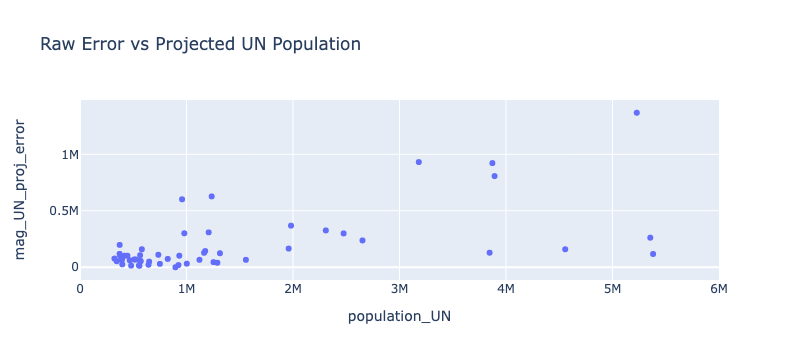

In [338]:
fig1 = px.scatter(cities, y = "mag_UN_proj_error", 
                  x = 'population_UN', hover_name='City', 
                  range_x=(0, 6000000), title = 'Raw Error vs Projected UN Population')
fig1.show()

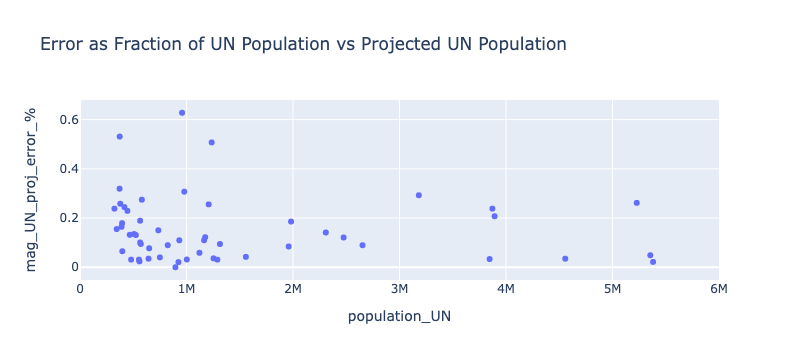

In [339]:
# Note we use used the magnitue of the raw error, because we are not 
# interested in whether they are over or under estimates, only if the 
# size of the error correlates with the size of the population predicted
fig2 = px.scatter(cities, y = "mag_UN_proj_error_%", x = 'population_UN',
                  hover_name='City', range_x=(0, 6000000),
                 title = 'Error as Fraction of UN Population vs Projected UN Population')
fig2.show()

**Observations**: 
- We can clearly see a correlation between the raw error and the UN projected Error. Larger population estimates can get much larger errors. 
- The **UN_proj_error_%** shows no relationship with UN population - it is independent of the size of the prediction. 

### Concerns about Measured Population Figures
The measured city data was sourced from [https://citypopulation.de/](https://citypopulation.de/) which provided 3 types of population estimate (defined [here](https://citypopulation.de/en/help/glossary/)): 
- **Population Census** - Directly measured and / or adjusted according to a nation wide census. 
- **Population Estimate** - Calculated using the current birth and death rates and the estimated migration or they are based on population registers. 
- **Population Projections** - Are calculations referring to the future, their accuracy is often poor. 

We believe the Population Census figures are typically reliable. We assume they are a source of truth, which we can directly compare to UN population predictions. We are not so sure about the Population estimates and Population projections. Since we have relatively few census population figures to use (because only a small number of countries have had a census since 2018) we think it is worth including these other possible less reliable figures.

We will start our analysis by comparing the 3 different estimate types to see if they show significantly different error trends. If they do, it may imply we should be careful when using them to estimate the accuracy of the UN projections. 

### Comparing Estimate Types
Below, we quantify the number of observations we have within each of the 3 city population estimate categories: 

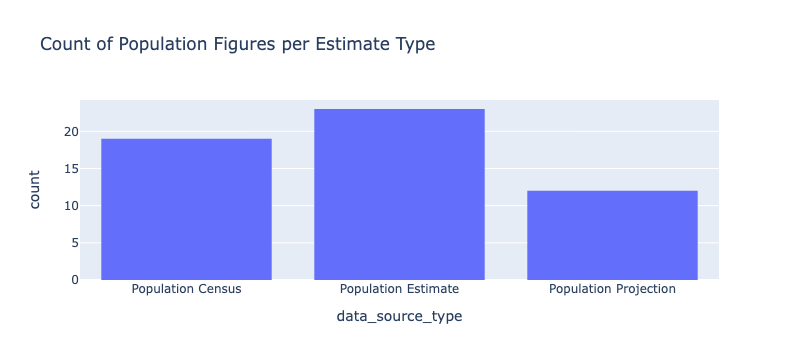

In [340]:
fig3 = px.histogram(cities, x = 'data_source_type', 
                    title = 'Count of Population Figures per Estimate Type')
fig3.show()

**Observations:**
- The majority of figures are Population Census (19 total) and Population Estimates (23 total), which we suspect are the more reliable figures. 
- We have relatively few Population Projections (12 total)

We now want to identify if the different estimate types show similar or different error trends. Firstly, we plot a histogram of the **UN_proj_error_%**, where we color each of the different estimate types separately:  

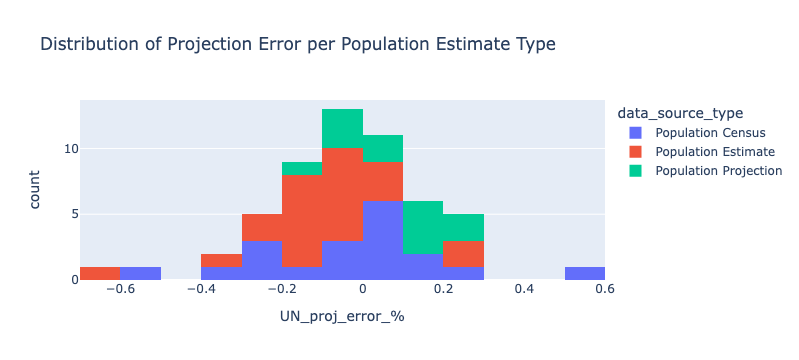

In [341]:
fig4 = px.histogram(cities, x="UN_proj_error_%",
                    color = 'data_source_type', 
                    title = 'Distribution of Projection Error per Population Estimate Type')
fig4.show()

**Observations**: 
- The overall distribution looks roughly normal distributed, with some large outlying values of around 60%.
- The **Population Projection** figures show the least variation and are closely spread around 0. This may suggest the population projections have relatively small errors because they follow a similar logic / methodology to the UN projections and are thus not really testing them. 
- The **Population Estimate** and **Population Census** are more spread out, with Estimates tending to lead to under-estimates (negative values) and census data tending to lead to over-estimates (positive values). This could suggest the estimates are generally overestimating the real populations (since it is shifted relative to what we suspect are the 'True' or trustworthy census values). 
- The spread in values for the 2 aforementioned variables may imply they are reflecting more real life variation from the projections and are therefore reliable. 

We will now look at a box plot of absolute error values (no negatives) to view the data in a different way: 

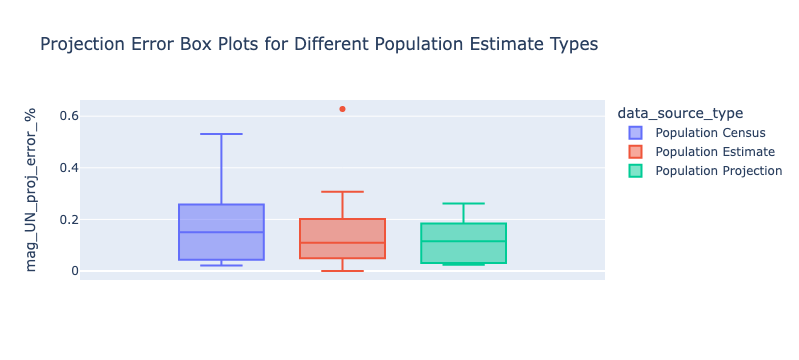

In [342]:
fig5 = px.box(cities, y="mag_UN_proj_error_%",  
              color = 'data_source_type', 
             title = 'Projection Error Box Plots for Different Population Estimate Types')
fig5.show()

**Observations:**
- We can clearly see that the Population Census data has the largest spread. The data is concentrated across a larger typical error value i.e. Population Census results lead to typically larger errors. 
- It looks like the Population Estimates and Population Projections have similar spreads, although the population Estimate data is concentrated over a slightly higher errors. Overall, we see a clear trend of lower typical errors and less spread of errors as we go from left to right. 
- If we assume that correct population figures are likely to show more spread and larger errors because the models will fail to account for the complexity and nuance of city population growth, then perhaps this means we can rely on the Census data most and should be increasingly skeptical of results from the Population Estimates and Population Projections.   

Finally, we will calculate some summary statistics for each estimate type and see what conclusions we can draw from them: 

In [343]:
metrics = ['mean', 'median', np.std, 'max', 'min']
cities.groupby('data_source_type')['UN_proj_error_%'].agg(metrics)

mean    median       std       max       min
data_source_type                                                       
Population Census     -0.032778  0.021041  0.234340  0.507310 -0.531148
Population Estimate   -0.079687 -0.084522  0.184166  0.292731 -0.627823
Population Projection  0.073150  0.084221  0.127437  0.261639 -0.179335

**Observations:** 
- If the median is positive, it means that the majority of observations are over-estimates. If it is negative, the majority are under-estimates. We can see that for both **Population Census** and **Population Projection** the median is positive, meaning that most predictions were over-estimates. This agrees with the histogram above. **Population Estimates** had a negative median and thus the majority of projections were under-estimates. This could imply the population estimates are typically over-estimating the population, leading to the apparent under-estimates from the UN predictions. 
- The mean is less useful / easy to understand, however it may weight the typical behaviour of under or over estimating according to the size of the over-estimate (e.g. perhaps there are fewer under-estimates but the ones that do occur are much larger). We can see that for **Population Census** the mean is negative and has a similar magnitude to the median (which is positive). This may suggest that while the majority of projections are over-estimates, some of the under-estimates are very large and pull the mean negative. For **Population Estimates** and **Population Projections** we see the mean and median are almost identical, suggesting that outliers have little impact. 
- Looking at standard deviation and min / max, we see that the **Population Census** errors have more spread and more outliers then **Population Estimates** or **Population Projections**. 
- Overall, the means and medians are typically small (~2.5% for **population Census** and ~8% for Population Estimates and **Population Projections**). This suggests no strong bias towards under-estimate or over-estimate. Given the small number of observations, any measured bias could easily be a statistical fluctuation.   

**Caution** - the small mean and median values for **Population Census** are **not** measures of typical accuracy. The negative and positive values cancel each other out, leading to smaller or larger values, this is a measure of balance. Performing the same calculation on the magnitude of the error yields very different results. 

**Conclusions:** 
- It seems clear that the **Population Census** data behaves quite differently to the **Population Estimate** and **Population Projection** data - It has a larger spread and typically larger errors. 
- We will treat **population census** data as the most reliable. 
- We will treat the **Population Estimate** and **Population Projection** data as fairly questionable. We believe the **Population Estimates** may be more reliable, but not by much, if at all. 

### What is the typical UN Projection Error? 
In this section, we will try to estimate the typical projection error in a UN population prediction. This typical error will be used by city planners to help them understand how reliable an estimate is likely to be. As such, we will be looking to create a **conservative estimate** that captures the **largest** likely error. This will hopefully allow city planners to bear in mind and prepare for worst case large errors in the prediction which could cause major problems in city planning. 

This means we will be looking for the largest error boundary that would capture the majority of population predictions. It will not however include **outliers**. We have explored 2 outliers to understand how they may be interpreted. In one case (Freetown in Sierra Leone) the census data has been called into question because it showed the population halve since the last census. In other cases, it seems the UN data was simply quite wrong. Either way, the typical error will be a measure of the maximum width of typical (i.e. the most common) projection errors.

We will create a rough estimate of the typical error by calculating the same statistical metrics above but this time on the magnitude of the error:  

In [344]:
cities.groupby('data_source_type')['mag_UN_proj_error_%'].agg(metrics)

mean    median       std       max       min
data_source_type                                                       
Population Census      0.174853  0.150237  0.154198  0.531148  0.021041
Population Estimate    0.143775  0.109804  0.137640  0.627823  0.000153
Population Projection  0.117446  0.115836  0.083847  0.261639  0.024128

**Observations:**
- As expected, we see that **Population Census** has the largest mean and median values, implying the largest typical error in predictions. It has a mean and median of 17% and 15% respectively, suggesting a typical error of ~16%. This seems relatively large, especially depending on the size of the UN population prediction (remember this error is a fraction of the UN population projection, so for a prediction of 500,000, the error would be +- 80,000 and for a projection of 1,000,000 this would double to +- 160,000). From a city planning perspective, this does seem like quite a large error, we would assume a city growing by 10% alone would be a lot, let alone having this margin of error in your prediction.
- We see a maximum error of about 50% and a minimum of 2%, showing that the predictions can be quite accurate (2% seems very respectable). 

The mean and median estimates of error are only rough estimates. They do not clearly define the number of projections whose errors sits within that threshold (e.g. the maximum error percentage for 80% of UN projections).

To get this data, we create a cumulative distribution plot below on the magnitude of the error: 

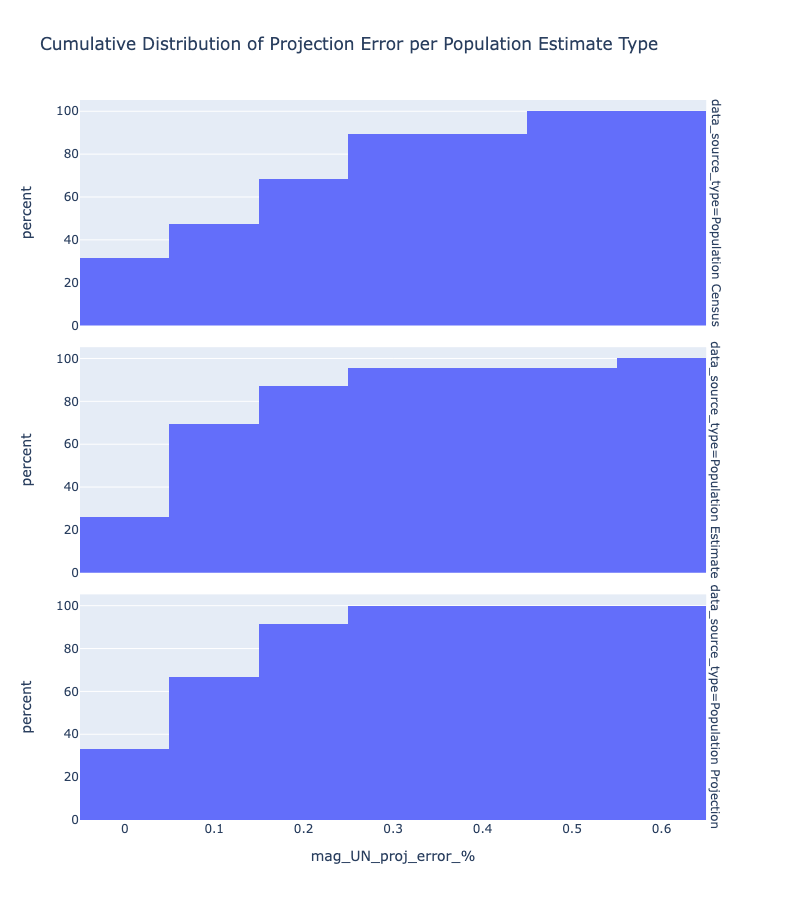

In [345]:
fig6 = px.histogram(cities, x = 'mag_UN_proj_error_%', cumulative=True, 
                    histnorm='percent', height = 900, 
                    facet_row='data_source_type',
                   title = 'Cumulative Distribution of Projection Error per Population Estimate Type')
fig6.show()

**Observations:**
- Looking at the **Population Census** data, we can see that 68% of the predictions have an error of 20% or less. This jumps to 89.5% with an error of 30% or less. Thus, we think a typical error of 30% offers a reliable and conservative maximum error to expect from a UN population prediction. The 20% error is more optimistic but may lead to city planners being caught out by a larger error.
- Both **Population Estimate** and **Population Projection** plots show that over 85% of predictions have an error of 20% or less - they show a much more optimistic result than what the Census data shows. 

**Conclusion:**
- We think that a city planner should anticipate a maximum typical error in a UN population prediction of **30%** if you are being conservative or **20%** if you wish to be more optimistic.
- The prediction is likely to have a lower error of around **~16%** most of the time and can be relatively small, within single digits. 

### Visualising The Typical Error
In the plots below, we have tried to showcase the difference between the UN population prediction and the measured population for all the data we gathered. Within this plot, we show the typical 30% error band and how well it captures the predictions in our data: 

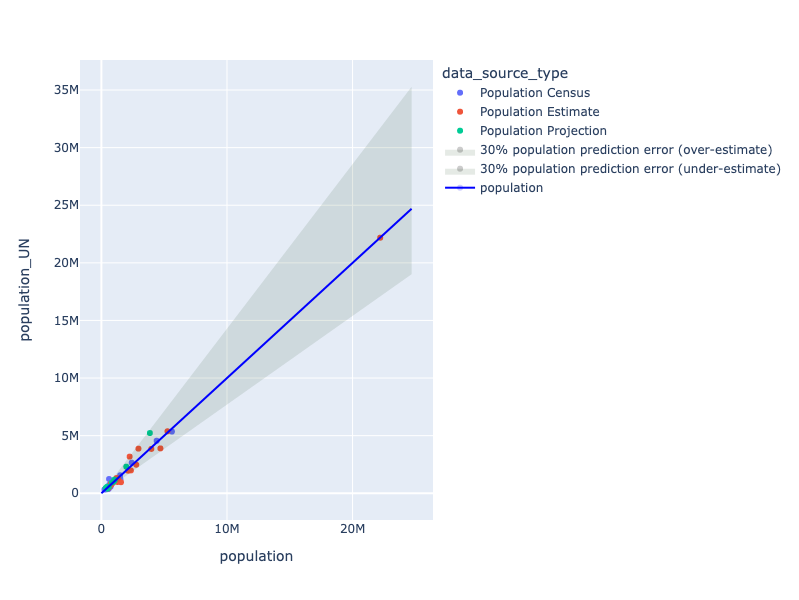

In [346]:
fig2 = px.scatter(cities, x="population", y = 'population_UN', 
                  color = 'data_source_type', #cities.years_since_UN_projection.astype(str),#',# 'data_source', #size = 'years_since_UN_projection', 
                  height = 600, #log_x=True, log_y=True,
                  
                hover_name = 'City', hover_data = ['Country_or_area',
       'City_Definition', 'year', 'UN_proj_error_%',
       'population_UN', 'data_source',
       'population', 'date_collected', 'years_since_UN_projection',
       'months_offset_from_midyear', 'year_offset_from_midyear',
        'UN_proj_error',
       'most_recent_UN_source', 'years_since_latest_UN_source']
             )

pop_max = cities.population.max()
extra = 2500000
max_pop_plotted = pop_max + extra

error = 0.3


max_plotted_error_pos = max_pop_plotted / (1 - error)
max_plotted_error_neg = max_pop_plotted / (1 + error)

invisible_line = go.scatter.Line(color='rgb(0,0,0)', width = 0)
visible_line = go.scatter.Line(color='blue')

marker = go.scatter.Marker(opacity =0)

fillcolor = 'rgba(0,50,0,0.1)'


fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_plotted_error_pos], 
               name="error_over", line_shape='linear', opacity = 0, line = invisible_line, marker = marker, showlegend=False)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="30% population prediction error (over-estimate)", 
               line_shape='linear', line= invisible_line, fill='tonexty', opacity = 0.01, marker = marker, fillcolor = fillcolor)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_plotted_error_neg], 
               name="error_under", line_shape='linear', opacity = 0.01, line=invisible_line,marker = marker, showlegend=False)
)


fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="30% population prediction error (under-estimate)", fillcolor= fillcolor,
               line_shape='linear', line= invisible_line, fill='tonexty' ,opacity = 0.01,marker = marker)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="population", fillcolor= fillcolor,
               line_shape='linear', line= visible_line ,marker = marker)
)


fig2.show()

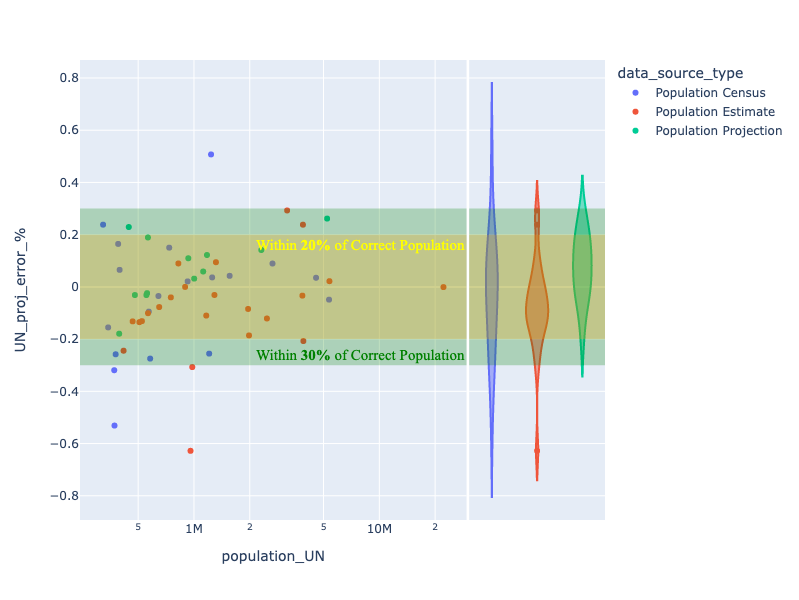

In [347]:
fig2 = px.scatter(cities, y="UN_proj_error_%", x = 'population_UN', color = 'data_source_type',
                  marginal_y = 'violin', log_x=True,
              #color = 'data_source', 
                  height = 600,
                  
                hover_name = 'City', hover_data = ['Country_or_area',
       'City_Definition', 'year',
       'population_UN', 'data_source',
       'population', 'date_collected', 'years_since_UN_projection',
       'months_offset_from_midyear', 'year_offset_from_midyear',
        'UN_proj_error',
       'most_recent_UN_source', 'years_since_latest_UN_source']
             )



fig2.add_hrect(y0=-0.3, y1=0.3,
              fillcolor="green", opacity=0.25, line_width=0, annotation_text="Within <b>30%</b> of Correct Population", annotation_position="inside bottom right",
              annotation=dict(font_size=15, font_family="Times New Roman", font_color = 'green'))


fig2.add_hrect(y0=-0.2, y1=0.2,
              fillcolor="orange", opacity=0.25, line_width=0, annotation_text="Within <b>20%</b> of Correct Population", annotation_position="inside top right",
              annotation=dict(font_size=15, font_family="Times New Roman", font_color = 'yellow'))

# Remove annotation text from marginal plot
fig2.layout.annotations = (fig2.layout.annotations[0], fig2.layout.annotations[2])


fig2.show()

### Other Insights

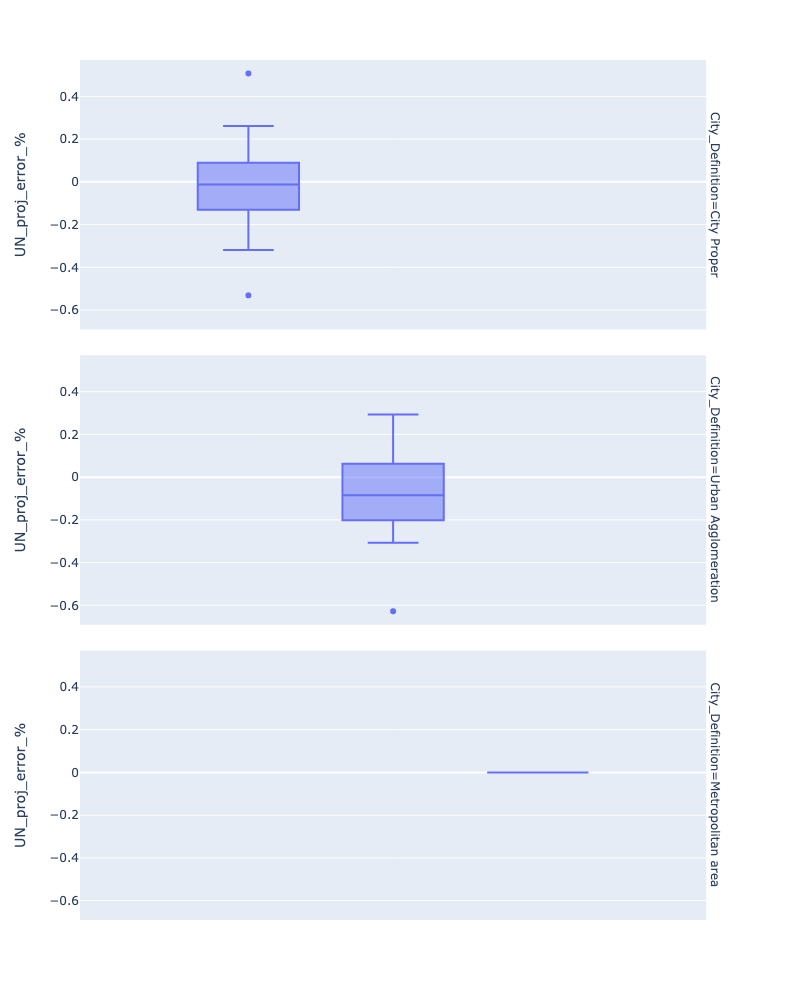

In [348]:
fig1 = px.box(cities.sort_values('years_since_UN_projection'), 
              y="UN_proj_error_%", 
              facet_row = 'City_Definition', height = 1000)
fig1.show()

In [349]:
# make notebook interactive on nb-viewer
import plotly

plotly.offline.init_notebook_mode()

## Appendix - Old Plots...please ignore

In [350]:
minimum - choose X, choose color, choose facet 
row....and I'll decide what in list to keep...maybe make year a string...

SyntaxError: unterminated string literal (detected at line 2) (2522992989.py, line 2)

In [ ]:
cities.columns

Why my calculation was wrong :(  ...UN error...population error...do calc myself...

issue is that the error is fraction of Population UN i.e. not percentage different from the real number (which is the (1 + 0.3)* population line) but the percentage different from the UN number i.e....damn I'm confused...

Consider what the actual difference in plotting is when you switch axes around...might help understand the issue...

In [ ]:
cities[['UN_proj_error', 'UN_proj_error_%']].describe()

**UN_proj_error**:
- Mean is positive 21,520, meaning an average over estimate of 21,450, on average its an over estimate when weighting by size of error. 
- Median is negative 17,022, meaning that in the majority of cases the projection is an underestimate and the without weighting by outliers, we underestimate by about 17,022. 
- std is 335,170, meaning the tendency away from the mean is high i.e. data is quite variable. However, this is misleading due to varying population sizes being projected, so percentage of UN population estimate is more meaningful. 

**UN_proj_error_%**:
- Mean is -0.03, meaning that the average, weighted by size of error, is 3%, which is very small.
- Median is also -0.03, the same as the mean, suggesting that when using percentages, the outliers are not significantly skewing the mean. Both mean the projections tend to under-estimate by a small amount, contrary to the typical documented issues. 
- The std is 0.2 i.e. 20%. This suggests the error tends to jump as high as 20% for 67% of the data (assuming a normal distribution). doubling this would cover 95% of data i.e. 40%. A 40% error seems quite large, and indeed a 20% error also seems quite large if cities are using the predictions to plan for housing etc. (20% of 300,000 is an error of 60,000. For 1,000,000 this jumps to 200,000.   

What are relative amounts of different figures...

In [ ]:
fig1 = px.histogram(cities, x="UN_proj_error_%", color = 'data_source_type')
fig1.show()

Is there significant difference in error i.e. typically larger errors for some types of figures - are they seemingly equally reliable...

2 conclusions - If anything, the estimates and projections may be more generous i.e. more likely to make UN look good, in line with same logic, and hence arriving at more similar results. The Census data is giving us worse results, so perhaps the census data is indeed more reliable. 

In [ ]:
fig1 = px.box(cities, y="UN_proj_error_%",  
              color = 'data_source_type', height = 600)
fig1.show()

Key takeaways - With census data, best data, 68% of time the error will be no larger that 20% 

about 90% of time less than 30% error

For estimates, it is about 87% of the time the error is less than 20% and about 95% of the time its less than 20%

Projected figures much more generous. 

In [ ]:
fig4 = px.histogram(cities, x = 'mag_UN_proj_error_%', cumulative=True, histnorm='percent')
fig4.show()

In [ ]:
fig4 = px.histogram(cities.sort_values('years_since_UN_projection'), x = 'mag_UN_proj_error_%', cumulative=True, histnorm='percent',
                    height = 1000, facet_row='years_since_UN_projection')
fig4.show()

In [ ]:

fig1 = px.histogram(cities, x = 'data_source')
fig1.show()

We can see that a 30% error gets 94% of the data - thats good coverage and shows our std before was a bit off. 

fig1 = px.box(cities.sort_values('years_since_UN_projection'), y="UN_proj_error_%", 
              facet_row = 'City_Definition', height = 1000)
fig1.show()- **We have relatively few observations to draw conclusions from.** As such, we expect that the best we can do is estimate a typical error range to anticipate for any given UN population prediction. It would be useful to be able to identify better or worse predictions (e.g. worse predictions further in the future) but we doubt they will have statistical rigour to rely on them. 

In [ ]:

fig1 = px.histogram(cities, x = 'data_source')
fig1.show()

In [ ]:
import plotly.express as px

fig1 = px.histogram(cities, x="City_Definition")
fig1.show()

In [ ]:
fig1 = px.histogram(cities, x="UN_proj_error_%", color = 'City_Definition')
fig1.show()

Outliers...are they mistakes? mis matches in city definitions for example? Investigated 2 and 1 was freetown where the census results are somewhat disputed, seeing a drop from million to 600,000 and the other is sirabe which showed the UN estimate for 2018 was significantly off. 

Probably best to basically try and cover the thick part of the distribution and treat the outliers as suspect or at least unlikely. 

Also, this also shows the errors are relative to the size of population estimate - show the raw errors, not nearly as nice a distribution. This seems somewhat intuitive and thats how the errors are most easily understood - a 20% error for a small population could be less impactful than the same 20% error for a large population...so large populations be careful? 

In [ ]:
fig1 = px.histogram(cities, x="years_since_UN_projection", color = 'data_source')
fig1.show()

In [ ]:
fig1 = px.scatter(cities, y="mag_UN_proj_error", x ='years_since_latest_UN_source', trendline = 'lowess', 
                  trendline_options=dict(frac=0.2))
fig1.show()

In [ ]:
cities.columns

Interesting Questions: 

- test box plot with mag, raw and % see if all agree...
- consider drop down added to make easier and let others see...
    
    
- why first year and 5th year since projection have largest error? What countries? What city definitions? What data source?  
- Do more data source analysis - group by Census vs Estimate. 
- Consider exponential smoothing of of-center data - can use full pop data to calculate the smoothing coefficient....years between will do it, can do with the dataframe...
- check all other variables for interesting ones
- consider what data is best to show / how - drop downs? Useful figures? Ways of displaying the data? Conclusions e.g. how much to trust the data? 

- Can we split the errors into buckets and assess the bucket error size? e.g. this big bucket of big errors...why? Can I identify the likely reason? 

so far, 'years since projection' and 'data_source' useful...'months_offset_from_midyear' as well...as you'd expect...could try to fix with **exponential smoothing**...

In [ ]:
fig1 = px.box(cities.sort_values('years_since_UN_projection'), y="UN_proj_error_%", 
              facet_row = 'City_Definition', height = 1000)
fig1.show()

In [ ]:
fig1 = px.box(cities, y= 'UN_proj_error_%' ,color = 'Country_or_area', height = 600)
fig1.show()

In [ ]:
fig1 = px.scatter(cities, y="mag_UN_proj_error_%", x ='years_since_UN_projection', trendline = 'lowess', color = 'data_source_type', 
                  trendline_options=dict(frac=0.1))
fig1.show()

In [ ]:
fig1 = px.scatter(cities, y="mag_UN_proj_error", x ='years_since_UN_projection', trendline = 'rolling', 
                  trendline_options=dict(function='median', window=5))
fig1.show()

In [ ]:
fig1 = px.histogram(cities, y="UN_proj_error", x ='years_since_latest_UN_source', histfunc='avg')
fig1.show()

In [ ]:
fig1 = px.violin(cities, x="UN_proj_error", color = 'data_source')
fig1.show()

In [ ]:
cities.UN_proj_error.mean()
cities.UN_proj_error.median()
cities.UN_proj_error.std()

In [ ]:
import plotly.graph_objects as go
fig2 = px.scatter(cities, x="population", y = 'population_UN', 
                  color = 'data_source_type', #cities.years_since_UN_projection.astype(str),#',# 'data_source', #size = 'years_since_UN_projection', 
                  height = 600, #log_x=True, log_y=True,
                  
                hover_name = 'City', hover_data = ['Country_or_area',
       'City_Definition', 'year', 'UN_proj_error_%',
       'population_UN', 'data_source',
       'population', 'date_collected', 'years_since_UN_projection',
       'months_offset_from_midyear', 'year_offset_from_midyear',
        'UN_proj_error',
       'most_recent_UN_source', 'years_since_latest_UN_source']
             )

pop_max = cities.population.max()
extra = 2500000
max_pop_plotted = pop_max + extra

error = 0.3


max_plotted_error_pos = max_pop_plotted / (1 - error)
max_plotted_error_neg = max_pop_plotted / (1 + error)

invisible_line = go.scatter.Line(color='rgb(0,0,0)', width = 0)
visible_line = go.scatter.Line(color='blue')

marker = go.scatter.Marker(opacity =0)

fillcolor = 'rgba(0,50,0,0.1)'


fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_plotted_error_pos], 
               name="error_over", line_shape='linear', opacity = 0, line = invisible_line, marker = marker, showlegend=False)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="30% population prediction error (over-estimate)", 
               line_shape='linear', line= invisible_line, fill='tonexty', opacity = 0.01, marker = marker, fillcolor = fillcolor)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_plotted_error_neg], 
               name="error_under", line_shape='linear', opacity = 0.01, line=invisible_line,marker = marker, showlegend=False)
)


fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="30% population prediction error (under-estimate)", fillcolor= fillcolor,
               line_shape='linear', line= invisible_line, fill='tonexty' ,opacity = 0.01,marker = marker)
)

fig2.add_trace(
    go.Scatter(x=[0, max_pop_plotted], y=[0,max_pop_plotted], name="population", fillcolor= fillcolor,
               line_shape='linear', line= visible_line ,marker = marker)
)


fig2.show()

Why my calculation was wrong :(  ...UN error...population error...do calc myself...

issue is that the error is fraction of Population UN i.e. not percentage different from the real number (which is the (1 + 0.3)* population line) but the percentage different from the UN number i.e....damn I'm confused...

Consider what the actual difference in plotting is when you switch axes around...might help understand the issue...

In [ ]:
fig2 = px.scatter(cities, y="UN_proj_error_%", x = 'population_UN', color = 'data_source_type',
                  marginal_y = 'violin', log_x=True,
              #color = 'data_source', 
                  height = 600,
                  
                hover_name = 'City', hover_data = ['Country_or_area',
       'City_Definition', 'year',
       'population_UN', 'data_source',
       'population', 'date_collected', 'years_since_UN_projection',
       'months_offset_from_midyear', 'year_offset_from_midyear',
        'UN_proj_error',
       'most_recent_UN_source', 'years_since_latest_UN_source']
             )



fig2.add_hrect(y0=-0.3, y1=0.3,
              fillcolor="green", opacity=0.25, line_width=0, annotation_text="Within <b>30%</b> of Correct Population", annotation_position="inside bottom right",
              annotation=dict(font_size=15, font_family="Times New Roman", font_color = 'green'))


fig2.add_hrect(y0=-0.2, y1=0.2,
              fillcolor="orange", opacity=0.25, line_width=0, annotation_text="Within <b>20%</b> of Correct Population", annotation_position="inside top right",
              annotation=dict(font_size=15, font_family="Times New Roman", font_color = 'yellow'))

# Remove annotation text from marginal plot
fig2.layout.annotations = (fig2.layout.annotations[0], fig2.layout.annotations[2])


fig2.show()

In [ ]:


fig2

In [ ]:
fig2.layout.annotations[0]

In [ ]:
fig2 = px.scatter(cities, x="years_since_latest_UN_source", y = 'UN_proj_error', 
                  color = 'most_recent_UN_source'
             )
fig2.show()

In [ ]:
cities.population.max()

In [ ]:
cities.columns

- maybe add a 'Census or Projection' bool for plotting...

In [ ]:
fig3 = px.scatter(cities, x="population", y = 'population_UN', color = 'data_source')
fig3.show()

In [ ]:
'100,00'.areplace(',','')

In [ ]:
cities[cities.population.isna()]

In [ ]:
#cities.population = 
cities.population.astype(str).str.replace(',','').astype(float)

In [ ]:
cities.to_csv('UN_projections_compared', index = False)

In [ ]:
cities_in_scope[cities_in_scope.City_fuzzy_match.isna()].City.unique()

Now we merge on country, city and year! hopefully get 1 year per city for the 

**Type up functions and then save to my personal cheat sheets...**

Manually fix in excel - spit out csv and manually fix then re-upload to get exact cities needed

Try same function above on the city names...if that doesnt work then...booo....maybe look into translation dictionary...


In [ ]:
a = {'1':'44'}

In [ ]:
a.values()

Approach: 
2 functions, 1 is to help choose the match method and the other is to do the match.

Choose method: 
Basically want to remove dupes on both sets (to minimise effort) then do match process in loop using all different scoring options then make a table showing the results.....

Then...proper matcher...

In [ ]:
m = [process.extract(key, s, limit=limit) for key in df_1[key1]] 


for country, match in zip(df_1[key1], m):
    print(country, match)

In [ ]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = [process.extract(x, s, limit=limit)  for key in df_1[key1]]  
    df_1['matches'] = m
    
    m2 = [', '.join([i[0] for i in x if i[1] >= threshold]) for match in df_1['matches']]
    df_1['matches'] = m2
    
    return df_1

In [ ]:
fuzzy_merge(UN_data, city_pop_after_UN, 'Country_or_area', 'country', threshold=80)

In [ ]:
pd.merge(x = )

cols of interest...: 
- years since projection
- Delta as raw number
- delta as % of original population...or of original projection? original projection is useful...accept a margin of error of blah against the projection

Other stuff: 
Could calculate the variance and average and stuff...overall oveestimatye with bl;ah bl;ah bl;ah.... 

In [ ]:
city_pop.dropna()

In [ ]:
country_data['Dijboiti']

In [ ]:
df1 = country_data['Dijboiti']

In [ ]:
df2 = country_data['kenya']

In [ ]:

pd.concat([df1, df2]).melt(['Name', 'Adm.'])

In [ ]:
a = ['all', 'bet_all', 'tim']

In [ ]:
'bet' in a

In [ ]:
os.chdir('..')
os.listdir()

 Do: 
- Breakdown into Census vs Estimate -> do they have same or different 94% error values? Are they seemingly as good as one another? 
- Review rest if what we know, identify good plots e.g. years since and data source and month offset...check above 2 and others as well...make sure everything quickly checked 
- get good views finalised, conclusions drawn, drop downs added, variable error based on percentage and justified
- notes, links to where data from etc. 

- Overall average....median....more over or under...



ideas: 
- breakdown of census types
- breakdown city types...
- breakdown last UN years data
- breakdown years since projections data

- Identify, in order of potential, all data variables that may be useful to understand UN error...look at cities columns

- explore each and see if you can find a likely predictor for errors...could use some of those cool data exploration tools...the tableu one...

- What about regressing the error...both mag and valued...using the selection tools could maybe help identify relevent variables...or elsoe box plots...

- box plots / distributuon of errors / violin plot
- standard deviation / estimated error in mean
- calculate mean...
- plot of projected vs real and broken down by stuff e.g. country, with diagonal line down middle
- add in data of last proper census...might be useful...might be manual...but can get from the UN data tables...not too bad really...look up country code, get data, and you are laughing! can add myself with vlookup...

- size of dots per years since...or population total...
- have fun...see what sounds cool and looks cool...

- Use my sexy display dataframe thing to get mean, median mode...maybe google to get these easily for a single column...desxcribe does as well I suppose...